In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
# from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import BayesianRidge
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error
import torch.optim as optim
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor  
from sklearn.model_selection import KFold, cross_val_score
import warnings
warnings.filterwarnings('ignore')

Code instead of using libraries directly 

In [2]:
def r2_score(y_true, y_pred):
    mean_true = sum(y_true) / len(y_true)
    ss_tot = sum((y_t - mean_true) ** 2 for y_t in y_true)
    ss_res = sum((y_t - y_p) ** 2 for y_t, y_p in zip(y_true, y_pred))
    return 1 - ss_res / ss_tot if ss_tot != 0 else 0

In [3]:
def mean_squared_error(y_true, y_pred, squared=True):
    mse = sum((y_t - y_p) ** 2 for y_t, y_p in zip(y_true, y_pred)) / len(y_true)
    return mse if squared else mse ** 0.5

In [4]:
def mean_absolute_error(y_true, y_pred):
    return sum(abs(y_t - y_p) for y_t, y_p in zip(y_true, y_pred)) / len(y_true)

In [5]:
class LinearRegression_:
    def __init__(self):
        self.coefficients = None
        self.intercept = None

    def fit(self, X, y):
        # Adding a column of ones for the intercept
        X = np.hstack([np.ones((X.shape[0], 1)), X])

        # Using the Normal Equation to compute the coefficients (beta)
        # beta = (X'X)^(-1)X'y
        X_transpose = X.T
        beta = np.linalg.inv(X_transpose.dot(X)).dot(X_transpose).dot(y)

        # First coefficient is the intercept, the rest are the coefficients for the predictors
        self.intercept = beta[0]
        self.coefficients = beta[1:]

    def predict(self, X):
        # Predict the values using the coefficients and intercept
        return X.dot(self.coefficients) + self.intercept

In [6]:
class Lasso_:
    def __init__(self, alpha, num_iters=1000, tol=1e-4):
        self.alpha = alpha
        self.num_iters = num_iters
        self.tol = tol

    def fit(self, X, y):
        m, n = X.shape
        self.w = np.zeros(n)  # Initialize weights
        for iteration in range(self.num_iters):
            w_old = self.w.copy()
            for j in range(n):
                y_pred = X.dot(self.w)
                rho = X[:, j].dot(y - y_pred + self.w[j] * X[:, j])
                self.w[j] = self._soft_thresholding(rho, self.alpha) / (X[:, j]**2).sum()
            if np.linalg.norm(self.w - w_old, ord=1) < self.tol:
                break

    def _soft_thresholding(self, rho, alpha):
        if rho > alpha:
            return rho - alpha
        elif rho < -alpha:
            return rho + alpha
        else:
            return 0

    def predict(self, X):
        return X.dot(self.w)

In [7]:
class Ridge_:
    def __init__(self, alpha, num_iters=1000, tol=1e-4):
        self.alpha = alpha
        self.num_iters = num_iters
        self.tol = tol

    def fit(self, X, y):
        m, n = X.shape
        self.w = np.zeros(n)  # Initialize weights
        X_norm = np.linalg.norm(X, axis=0)
        X = X / X_norm  # Normalize X
        y_mean = y.mean()
        for iteration in range(self.num_iters):
            w_old = self.w.copy()
            y_pred = X.dot(self.w)
            rho = X.T.dot(y - y_pred) + self.alpha * self.w
            self.w = rho / (X.T.dot(X) + self.alpha * np.eye(n)).sum(axis=1)
            if np.linalg.norm(y - X.dot(self.w), ord=2) < np.linalg.norm(y - y_mean, ord=2) * self.tol:
                break

    def predict(self, X):
        X_norm = np.linalg.norm(X, axis=0)
        X = X / X_norm  # Normalize X
        return X.dot(self.w)

## Data Reading

In [8]:
df = pd.read_csv('laptop_data_train.csv')
df.head()

,Number,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
0,0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,71378.6832
1,1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,47895.5232
2,2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,30636.0000
3,3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,135195.3360
4,4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,96095.8080


In [9]:
df_test = pd.read_csv('laptop_data_test.csv')

In [10]:
df_test.head()

,Number,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
0,0,Asus,Gaming,17.3,IPS Panel Full HD 1920x1080,Intel Core i7 6820HK 2.7GHz,32GB,256GB SSD + 256GB SSD,Nvidia GeForce GTX 980M,Windows 10,3.58kg,68145.1200
1,1,Dell,2 in 1 Convertible,13.3,Full HD / Touchscreen 1920x1080,Intel Core i7 7Y75 1.3GHz,16GB,256GB SSD,Intel HD Graphics 615,Windows 10,1.22kg,87858.7200
2,2,Lenovo,Ultrabook,14.0,IPS Panel Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,8GB,256GB Flash Storage,Intel HD Graphics 620,Windows 10,1.13kg,109170.7200
3,3,Lenovo,Notebook,15.6,IPS Panel Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,512GB SSD,Intel HD Graphics 620,Windows 10,1.95kg,104588.1072
4,4,LG,Ultrabook,15.6,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i7 7500U 2.7GHz,16GB,512GB SSD,Intel HD Graphics 620,Windows 10,1.08kg,111834.7200


In [11]:
unique_counts = df_test.apply(lambda col: col.nunique())

unique_counts

Number              402
Company              13
TypeName              6
Inches               11
ScreenResolution     23
Cpu                  59
Ram                   8
Memory               28
Gpu                  59
OpSys                 7
Weight              109
Price               301
dtype: int64

In [12]:
unique_counts = df.apply(lambda col: col.nunique())

unique_counts

Number              901
Company              19
TypeName              6
Inches               17
ScreenResolution     37
Cpu                 100
Ram                   8
Memory               33
Gpu                  96
OpSys                 9
Weight              161
Price               600
dtype: int64

In [13]:
# We can conclude that the column 'Number' won't be affecting our output and it is safe to drop the column

In [14]:
df.isnull().sum()

Number              0
Company             0
TypeName            0
Inches              0
ScreenResolution    0
Cpu                 0
Ram                 0
Memory              0
Gpu                 0
OpSys               0
Weight              0
Price               0
dtype: int64

## EDA, Pre-Processing steps and Feature-Engineering

Feature Engineering for column 'Ram' and 'Weight'

Understanding the dataset with Exploratory Data Analysis (EDA)

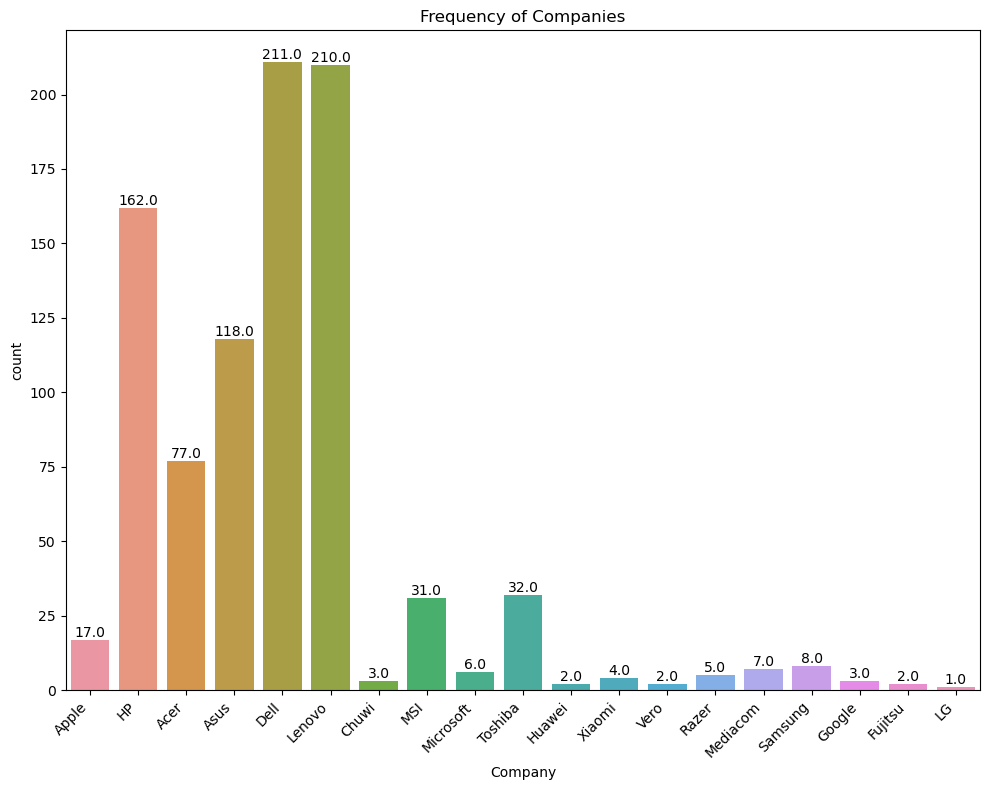

In [15]:
# Bar plot for column - Company
plt.figure(figsize=(10, 8))

ax = sns.countplot(data=df, x='Company')

plt.xticks(rotation=45, ha='right')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title('Frequency of Companies')
plt.tight_layout()
plt.show()
plt.show()

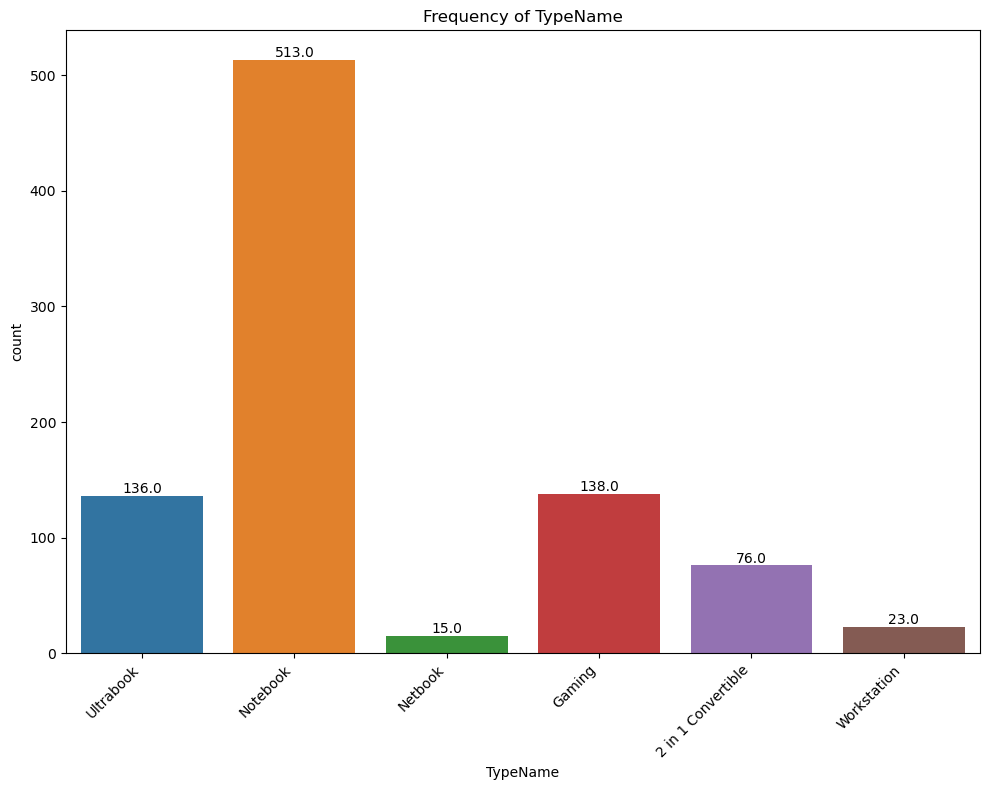

In [16]:
# Bar plot for column - TypeName
plt.figure(figsize=(10, 8))

ax = sns.countplot(data=df, x='TypeName')

plt.xticks(rotation=45, ha='right')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title('Frequency of TypeName')
plt.tight_layout()
plt.show()
plt.show()

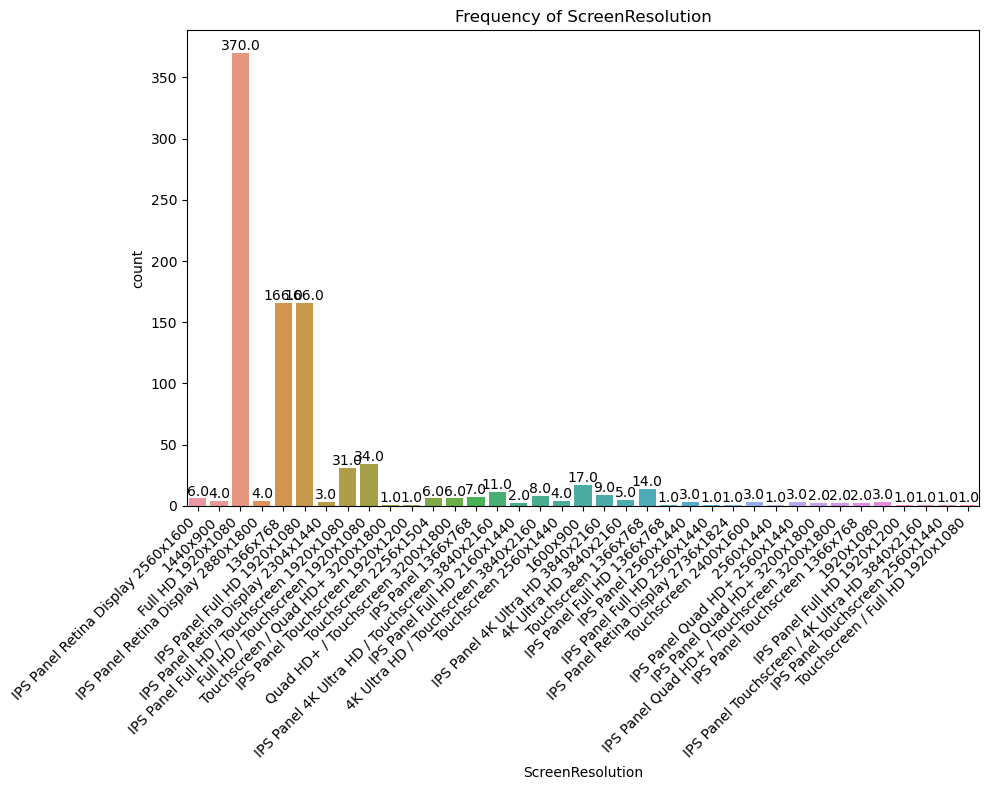

In [17]:
# Bar plot for column - ScreenResolution
plt.figure(figsize=(10, 8))

ax = sns.countplot(data=df, x='ScreenResolution')

plt.xticks(rotation=45, ha='right')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title('Frequency of ScreenResolution')
plt.tight_layout()
plt.show()
plt.show()

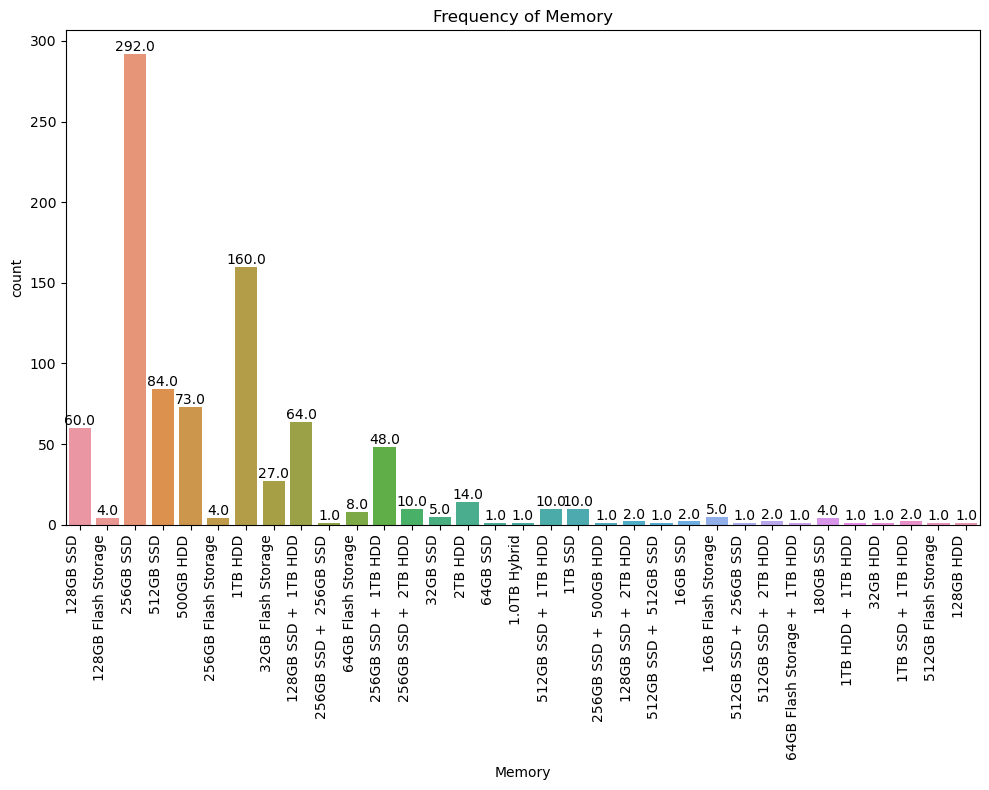

In [18]:
# Bar plot for column - Memory
plt.figure(figsize=(10, 8))

ax = sns.countplot(data=df, x='Memory')

plt.xticks(rotation=90, ha='right')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title('Frequency of Memory')
plt.tight_layout()
plt.show()
plt.show()

# Cpu, Gpu column has too many unique values as we saw above, we would have to deal with them differently

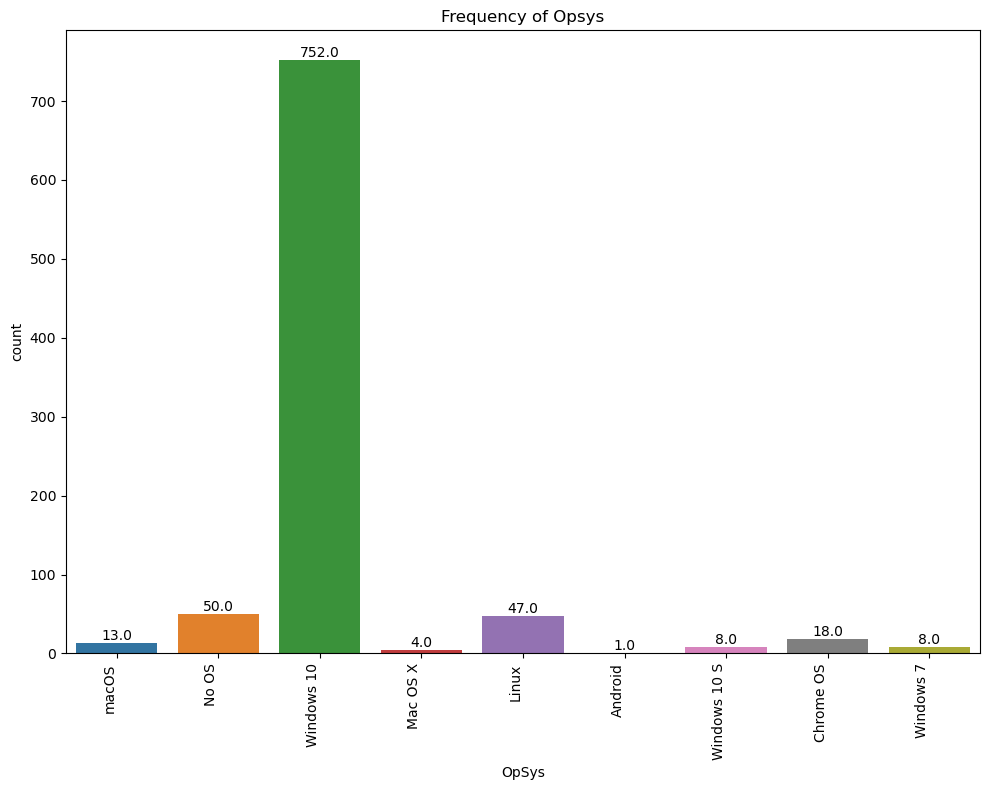

In [19]:
# Bar plot for column - Opsys
plt.figure(figsize=(10, 8))

ax = sns.countplot(data=df, x='OpSys')

plt.xticks(rotation=90, ha='right')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title('Frequency of Opsys')
plt.tight_layout()
plt.show()
plt.show()

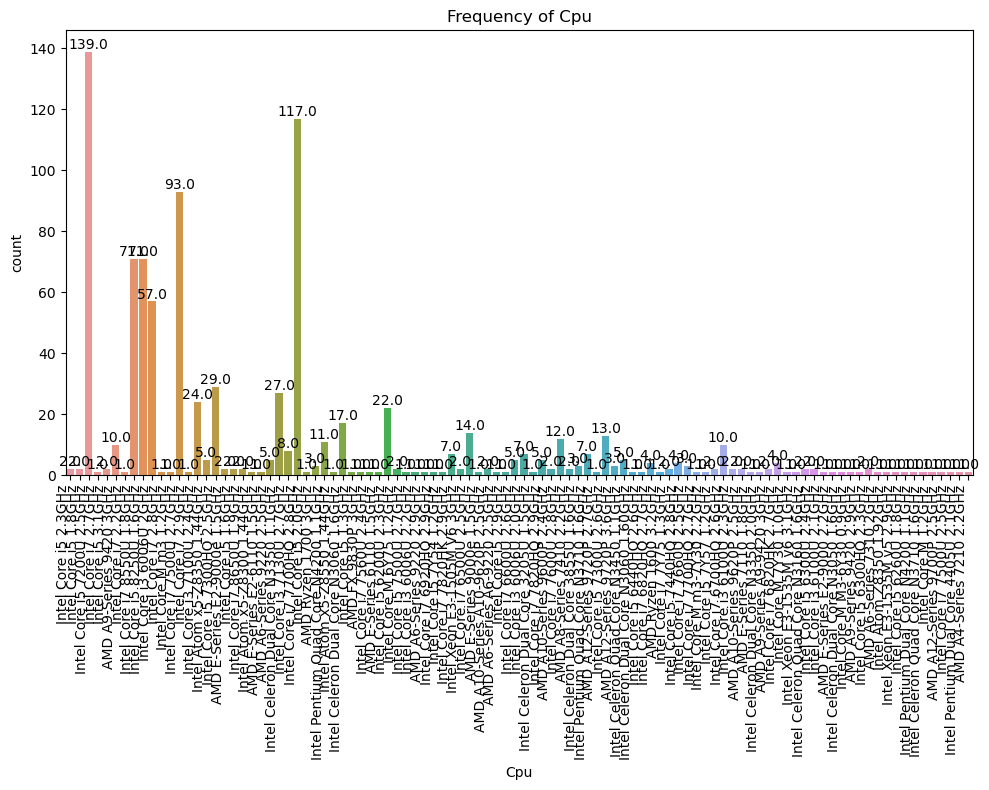

In [20]:
# Bar plot for column - Cpu
plt.figure(figsize=(10, 8))

ax = sns.countplot(data=df, x='Cpu')

plt.xticks(rotation=90, ha='right')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title('Frequency of Cpu')
plt.tight_layout()
plt.show()
plt.show()

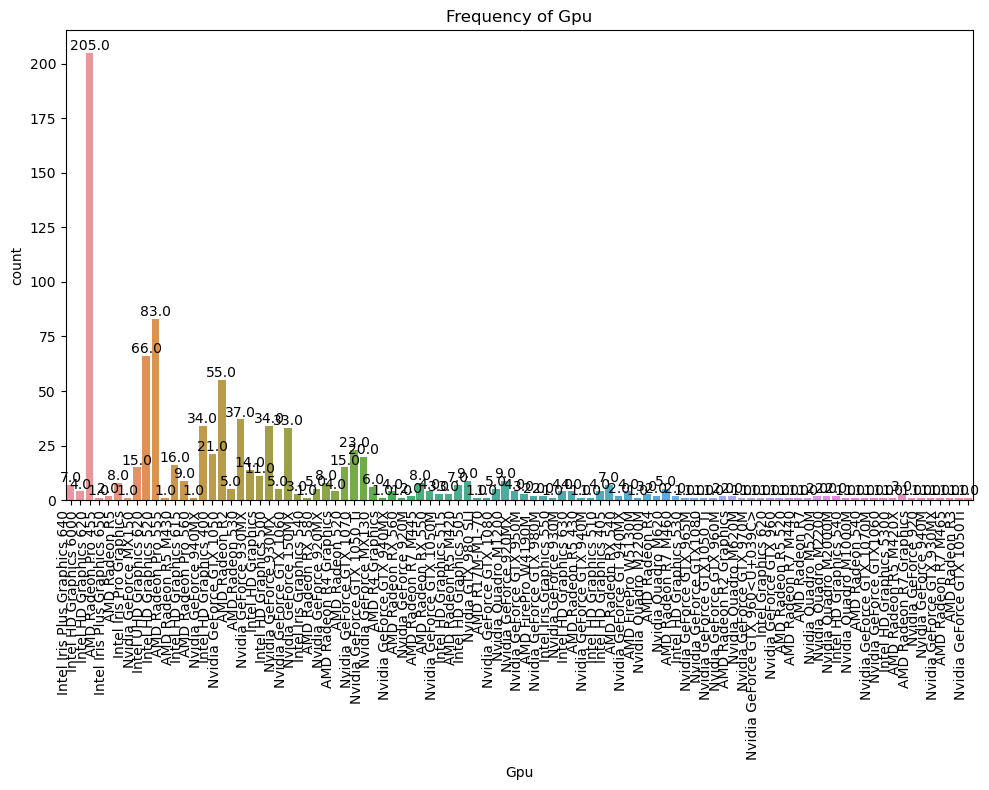

In [21]:
# Bar plot for column - Gpu
plt.figure(figsize=(10, 8))

ax = sns.countplot(data=df, x='Gpu')

plt.xticks(rotation=90, ha='right')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title('Frequency of Gpu')
plt.tight_layout()
plt.show()
plt.show()

In [22]:
columns_to_check = ['Cpu','Gpu']
unique_values = {}
for column in columns_to_check:
    unique_values[column] = df[column].unique()
for column, values in unique_values.items():
    print('\n')
    print(f"Unique values in '{column}': {values}")



Unique values in 'Cpu': ['Intel Core i5 2.3GHz' 'Intel Core i5 1.8GHz'
 'Intel Core i5 7200U 2.5GHz' 'Intel Core i7 2.7GHz'
 'Intel Core i5 3.1GHz' 'AMD A9-Series 9420 3GHz' 'Intel Core i7 2.2GHz'
 'Intel Core i7 8550U 1.8GHz' 'Intel Core i5 8250U 1.6GHz'
 'Intel Core i3 6006U 2GHz' 'Intel Core i7 2.8GHz'
 'Intel Core M m3 1.2GHz' 'Intel Core i7 7500U 2.7GHz'
 'Intel Core i7 2.9GHz' 'Intel Core i3 7100U 2.4GHz'
 'Intel Atom x5-Z8350 1.44GHz' 'Intel Core i5 7300HQ 2.5GHz'
 'AMD E-Series E2-9000e 1.5GHz' 'Intel Core i5 1.6GHz'
 'Intel Core i7 8650U 1.9GHz' 'Intel Atom x5-Z8300 1.44GHz'
 'AMD E-Series E2-6110 1.5GHz' 'AMD A6-Series 9220 2.5GHz'
 'Intel Celeron Dual Core N3350 1.1GHz' 'Intel Core i3 7130U 2.7GHz'
 'Intel Core i7 7700HQ 2.8GHz' 'Intel Core i5 2.0GHz'
 'AMD Ryzen 1700 3GHz' 'Intel Pentium Quad Core N4200 1.1GHz'
 'Intel Atom x5-Z8550 1.44GHz' 'Intel Celeron Dual Core N3060 1.6GHz'
 'Intel Core i5 1.3GHz' 'AMD FX 9830P 3GHz' 'Intel Core i7 7560U 2.4GHz'
 'AMD E-Series 6110 

Feature Engineering for 'Cpu' and 'Gpu'

Idea used in deciding if GPU is integrated or discrete :

The determination of whether a GPU (Graphics Processing Unit) is integrated or discrete in the provided code is based on general knowledge about the brands and models typically associated with each type:

1. **Integrated GPUs**:
   - These are typically built into the same chip as the CPU and share memory with the CPU.
   - For the `Intel` brand, the integrated GPUs usually come with naming patterns like `Intel HD Graphics`, `Intel UHD Graphics`, `Intel Iris Plus Graphics`, etc.

2. **Discrete GPUs**:
   - These are separate pieces of hardware with their own dedicated memory.
   - `Nvidia` and `AMD` are known for manufacturing discrete GPUs. Nvidia's discrete GPUs often have names that start with `GeForce`, `Quadro`, or `Titan`. AMD's discrete GPUs usually start with `Radeon`.

In the code snippet, the GPU type is set as "Discrete" if the text contains "Nvidia", "GeForce", "Quadro", or "Radeon" which are indicative of discrete GPUs from Nvidia and AMD. If the text contains "Intel", it is assumed to be an integrated GPU because Intel is known for integrated graphics solutions.

Here are the general rules used in the code:

- If the GPU description contains `Nvidia`, `GeForce`, or `Quadro`, the type is set to "Discrete" since these terms are associated with Nvidia's discrete GPUs.
- If the GPU description contains `AMD` or `Radeon`, the type is set to "Discrete" as these terms are linked to AMD's discrete GPU products.
- If the GPU description contains `Intel`, the type is set to "Integrated" because Intel's GPUs built into their CPUs are integrated.

It's important to note that this approach is heuristic-based and assumes all GPUs that are not explicitly from Nvidia or AMD (and hence are discrete) are integrated. This might not always be accurate as there are exceptions and edge cases; for instance, Intel has released discrete GPUs under the Xe brand, which would not be captured by the current sqrtic. The code would need to be updated to account for such cases if they are present in your dataset.

In [23]:

def parse_cpu(text):
    brand = "Intel" if "Intel" in text else "AMD" if "AMD" in text else None
    model = text.split()[2] if brand else None
    speed = text.split()[-1] if brand else None
    return pd.Series([brand, model, speed], index=['cpu_brand', 'cpu_model', 'cpu_speed'])

# Function to extract GPU brand, model, and type
def parse_gpu(text):
    brand = None
    model = None
    gpu_type = None
    if "Nvidia" in text or "GeForce" in text or "Quadro" in text:
        brand = "Nvidia"
        model = text.split('Nvidia')[-1].strip()
        gpu_type = "Discrete"
    elif "AMD" in text or "Radeon" in text:
        brand = "AMD"
        model = text.split('AMD')[-1].strip()
        gpu_type = "Discrete"
    elif "Intel" in text:
        brand = "Intel"
        model = text.split('Intel')[-1].strip()
        gpu_type = "Integrated"

    return pd.Series([brand, model, gpu_type], index=['gpu_brand', 'gpu_model', 'gpu_type'])

def mean(ls):
    ls1 = sorted(ls, reverse=True)
    ls1 = ls1[:3]
    return sum(ls1) / len(ls1)


In [24]:
# Screen Resolution Feature Engineering
def parse_screen_resolution(text):
    resolution = text.split()[-1]
    width, height = resolution.split('x')
    is_ips = 'IPS' in text
    is_retina = 'Retina' in text
    is_touchscreen = 'Touchscreen' in text
    # You can add more parsing sqrtic for other screen types
    return pd.Series([width, height, is_ips, is_retina, is_touchscreen], index=['resolution_width', 'resolution_height', 'is_ips', 'is_retina', 'is_touchscreen'])

In [25]:
# Memory Feature Engineering
def parse_memory(text):
    ssd_capacity = sum(int(x) for x in re.findall(r'(\d+)GB SSD', text))
    hdd_capacity = sum(int(x) for x in re.findall(r'(\d+)GB HDD', text)) + sum(int(x)\
                            * 1024 for x in re.findall(r'(\d+)TB HDD', text))
    flash_storage_capacity = sum(int(x) for x in re.findall(r'(\d+)GB Flash Storage', text))
    hybrid_indicator = 'Hybrid' in text or '+' in text
    total_storage = ssd_capacity + hdd_capacity + flash_storage_capacity
    # Note that 1TB = 1024GB, so you may need to handle that conversion if needed.
    return pd.Series([ssd_capacity, hdd_capacity, flash_storage_capacity, hybrid_indicator, total_storage], index=['ssd_capacity_gb', 'hdd_capacity_gb', 'flash_storage_capacity_gb', 'is_hybrid_storage', 'total_storage_gb'])

In [26]:
# Function to extract manufacturer or series from GPU model
def extract_gpu_series(gpu_model):
    if 'NVIDIA' in gpu_model:
        return 'NVIDIA'
    elif 'AMD' in gpu_model:
        return 'AMD'
    elif 'Intel' in gpu_model:
        return 'Intel'
    else:
        return 'Other'



In [27]:
def pre_processing(df,df_test):
  
    df = pd.concat([df,df_test],ignore_index=True)
    df.drop(columns=['Number'], inplace= True)
    df['Ram'] = df['Ram'].str.replace('GB', '').astype('int32')
    df['Weight'] = df['Weight'].str.replace('kg', '').astype('float32')

    df[['cpu_brand', 'cpu_model', 'cpu_speed']] = df['Cpu'].apply(parse_cpu)
    df[['gpu_brand', 'gpu_model', 'gpu_type']] = df['Gpu'].apply(parse_gpu)
    df = df.dropna()
    df[['resolution_width', 'resolution_height', 'is_ips', 'is_retina', 'is_touchscreen']]  = df['ScreenResolution'].apply(parse_screen_resolution)
    df[['ssd_capacity_gb', 'hdd_capacity_gb', 'flash_storage_capacity_gb', 'is_hybrid_storage', 'total_storage_gb']] = df['Memory'].apply(parse_memory)
    df['Gpu_Manufacturer'] = df['Gpu'].apply(extract_gpu_series)

    columns_to_encode = ['Company', 'TypeName', 'OpSys', 'cpu_brand', 'cpu_model','gpu_brand','gpu_type','Gpu_Manufacturer']
    column_indices = [df.columns.get_loc(col) for col in columns_to_encode]

    binary_step = ColumnTransformer(transformers=[
        ('col_tnf', OneHotEncoder(sparse=False, drop='first'), column_indices)
    ], remainder='passthrough')

    transformed_data = binary_step.fit_transform(df)


    new_feature_names = binary_step.named_transformers_['col_tnf'].get_feature_names_out(columns_to_encode)

    non_transformed_columns = [df.columns[index] for index in range(df.shape[1]) if index not in column_indices]

    all_feature_names = list(new_feature_names) + non_transformed_columns

    transformed_df = pd.DataFrame(transformed_data, columns=all_feature_names)

    transformed_df.head()

    transformed_df['cpu_speed'] = transformed_df['cpu_speed'].str.replace('GHz', '').astype(float)

    columns_to_drop = ['ScreenResolution', 'Cpu', 'Memory', 'Gpu', 'gpu_model']

    df_final = transformed_df.drop(columns=columns_to_drop)
    df_final = df_final.apply(lambda x: pd.to_numeric(x, errors='coerce')if x.dtype == 'object' else x)

    # numeric_columns = ['Weight','Ram', 'cpu_speed', 'resolution_width', 'resolution_height','ssd_capacity_gb','hdd_capacity_gb', 'flash_storage_capacity_gb', 'Inches']
    # skewness = df_final[numeric_columns].skew()

    # for col in numeric_columns:
    #     # df_final[col] = np.log1p(df_final[col])

    #     if skewness[col] > 1:
    #         print(f"Skewness of {col} > 1, applying log")
    #         df_final[col] = np.log1p(df_final[col])
    #     elif skewness[col] < -1:
    #         print(f"Skewness of {col} < -1, applying cube")
    #         df_final[col] = np.power(df_final[col], 3)
    
    df_prep = df_final.iloc[:901]
    df_test_prep = df_final.iloc[901:]
    # scaler = StandardScaler()

    # # Fit the scaler to the specified columns and transform them
    # df_prep[numeric_columns] = scaler.fit_transform(df_prep[numeric_columns])
    # df_test_prep[numeric_columns] = scaler.transform(df_test_prep[numeric_columns])
    return df_prep,df_test_prep

Preprocessing Train and Test data

In [28]:
df_prep, df_test_prep = pre_processing(df,df_test)

### Trivial Method

In [29]:
X = df_prep.drop(columns=['Price'])
y = df_prep['Price']
X_test = df_test_prep.drop(columns=['Price'])
y_test = df_test_prep['Price']
# Split your dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=2)

trivial_prediction = np.mean(y_train)
y_pred = np.full(len(y_val),trivial_prediction)

print("Validation Scores")
print('R2 score:', r2_score(y_val, y_pred))
print('MAE:', mean_absolute_error(y_val, y_pred))
print('RMSE:', mean_squared_error(y_val, y_pred, squared= False))

y_test_pred = np.full(len(y_test),trivial_prediction)

print("Test Scores")
print('R2 score:', r2_score(y_test, y_test_pred))
print('MAE:', mean_absolute_error(y_test, y_test_pred))
print('RMSE:', mean_squared_error(y_test, y_test_pred, squared= False))


Validation Scores
R2 score: -0.0003585192890618316
MAE: 27372.763322352945
RMSE: 36870.63314097856
Test Scores
R2 score: -0.004990796572328371
MAE: 27918.492087381543
RMSE: 35943.851379348656


### Baseline Linear Regression 

In [30]:
numeric_columns = ['Weight','Ram', 'cpu_speed', 'resolution_width', 'resolution_height','ssd_capacity_gb','hdd_capacity_gb', 'flash_storage_capacity_gb', 'Inches']
skewness = df_prep[numeric_columns].skew()
df_prep1 = df_prep.copy(deep=True)
df_test_prep1 = df_test_prep.copy(deep=True)
for col in numeric_columns:
        # df_final[col] = np.log1p(df_final[col])
    if skewness[col] > 1:
        df_prep1[col] = np.log1p(df_prep1[col])
        df_test_prep1[col] = np.log1p(df_test_prep1[col])
    elif skewness[col] < -1:
        df_prep1[col] = np.power(df_prep1[col], 3)
        df_test_prep1[col] = np.power(df_test_prep1[col], 3)
X = df_prep1.drop(columns=['Price'])
y = df_prep1['Price']
X_test = df_test_prep1.drop(columns=['Price'])
y_test = df_test_prep1['Price']

model = LinearRegression()

model.fit(X,y)
kf = KFold(n_splits=10, shuffle=True, random_state=42)
r2_scores = cross_val_score(model,X,y,cv=kf,scoring='r2')
r2_score_val = mean(r2_scores)

mae_scores = cross_val_score(model,X,y,cv=kf,scoring='neg_mean_absolute_error')
mae_score = -mean(mae_scores)

rmse_scores = cross_val_score(model,X,y,cv=kf,scoring='neg_root_mean_squared_error')
rmse_score = -mean(rmse_scores)
print("Average Validation Scores")
print('R2 score:', r2_score_val)
print('MAE:', mae_score)
print('RMSE:', rmse_score)

y_test_pred = model.predict(X_test)


print("\nTest Scores")
print('R2 score:', r2_score(y_test, y_test_pred))
print('MAE:', mean_absolute_error(y_test, y_test_pred))
print('RMSE:', mean_squared_error(y_test, y_test_pred, squared= False))

Average Validation Scores
R2 score: 0.8344537662198303
MAE: 12077.929712859486
RMSE: 15888.338657389642

Test Scores
R2 score: 0.6331726919863121
MAE: 15975.831516093658
RMSE: 21715.728182457497


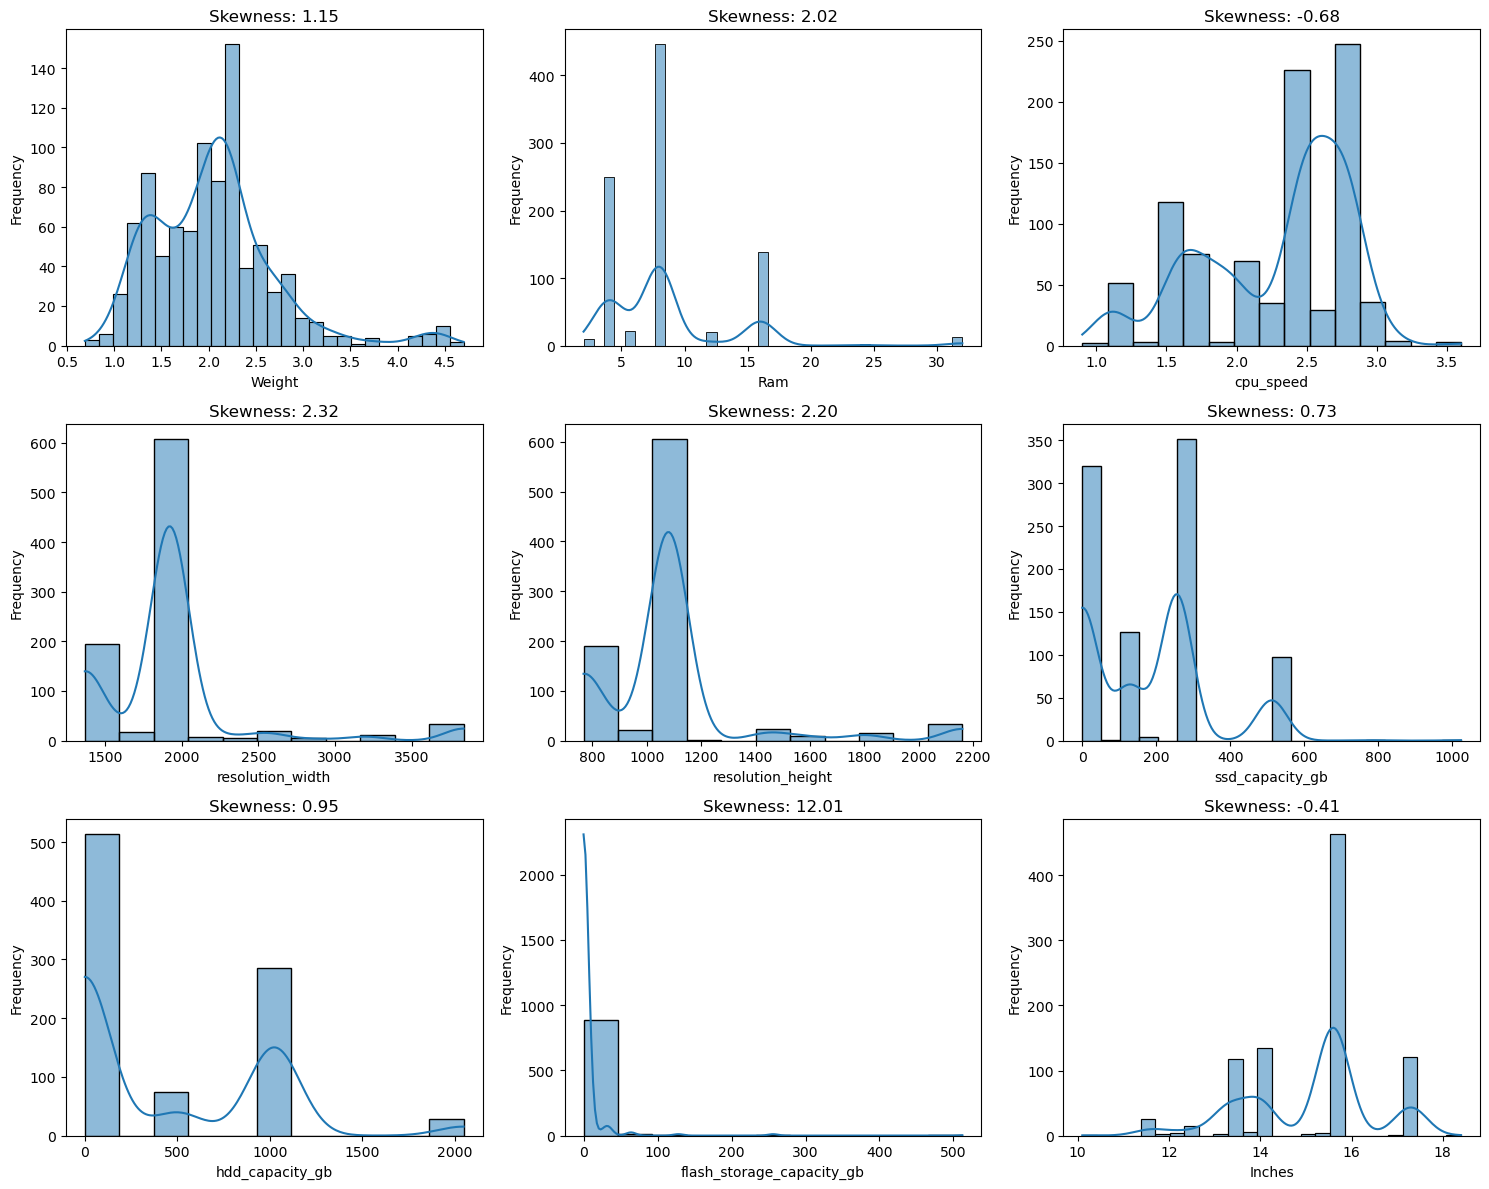

In [31]:

num_plots = len(numeric_columns)
cols = 3
rows = num_plots // cols + (num_plots % cols > 0)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()  

for i, col in enumerate(numeric_columns):
    sns.histplot(df_prep[col], kde=True, ax=axes[i])
    axes[i].title.set_text(f'Skewness: {skewness[col]:.2f}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')


for ax in axes[num_plots:]:
    ax.remove()

plt.tight_layout()
plt.show()

### Feature Selection Methods

1. Univariate feature selection - I will be plotting number of features vs R2, MAE, MSE and select the optimum number of features

Univariate Feature Selection (UFS) refers to the process of selecting features based on univariate statistical tests between each feature and the target variable.

ANOVA (Analysis of Variance) F-test

In [32]:
X = df_prep.drop(columns=['Price'])
y = df_prep['Price']
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')
X_test = df_test_prep.drop(columns=['Price'])
y_test = df_test_prep['Price']

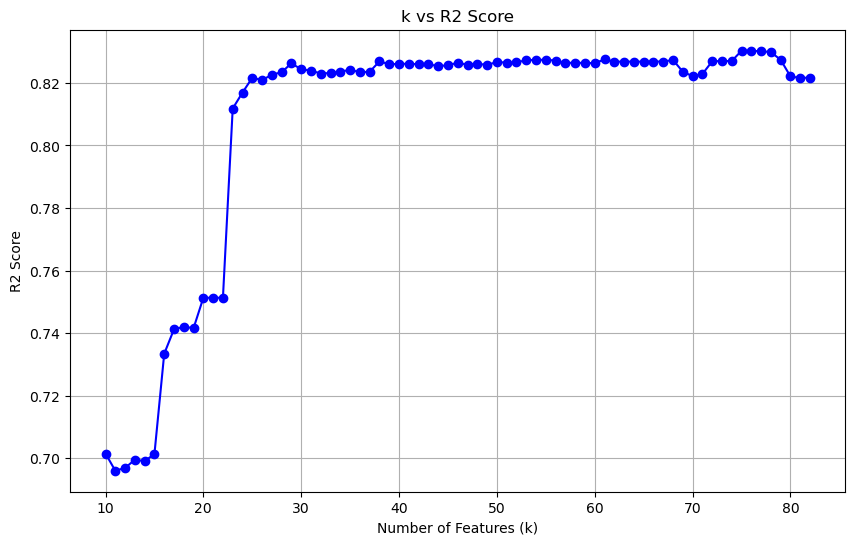

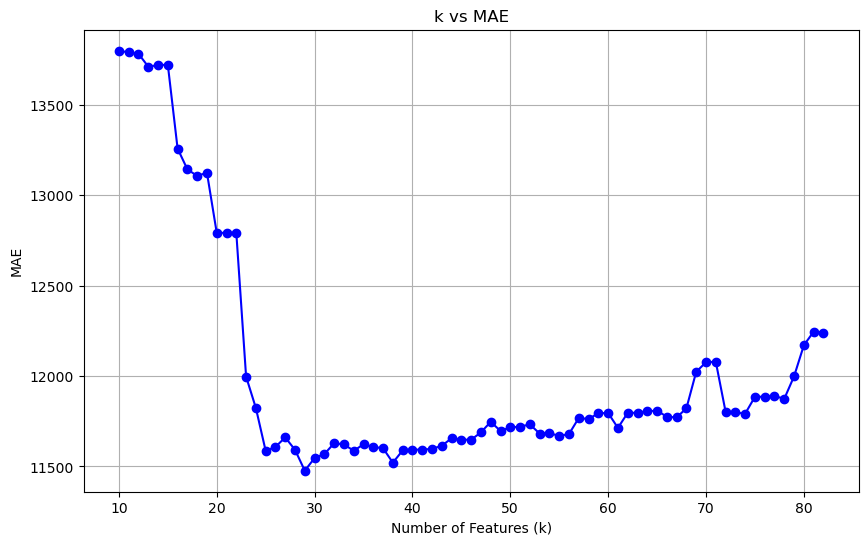

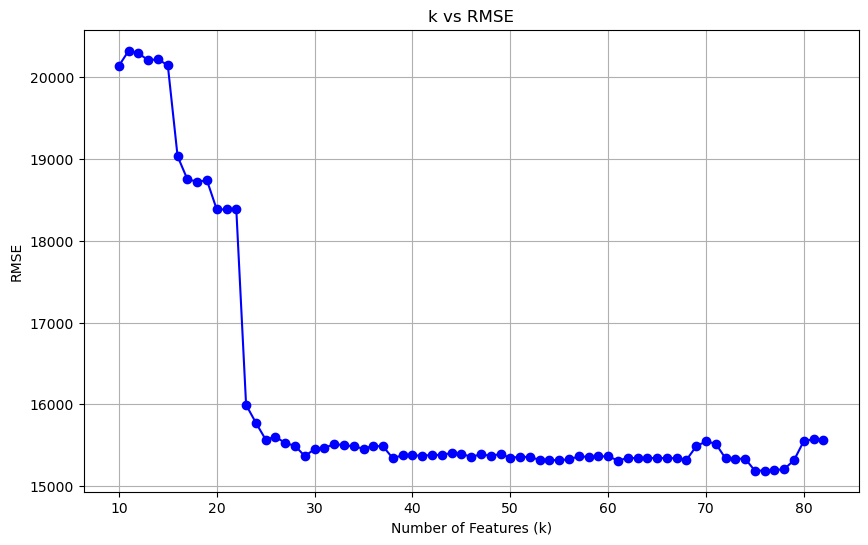

Best R2 k = 75, Best MAE k = 29


In [33]:
model = LinearRegression()
k_values = list(range(10, 83))

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=2)
r2_scores = []
mae_val = []
RMSE_val = []

for k in k_values:
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_val_selected = selector.transform(X_val)
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_val_selected)
    r2_scores.append(r2_score(y_val, y_pred))
    mae_val.append(mean_absolute_error(y_val, y_pred))
    RMSE_val.append(mean_squared_error(y_val, y_pred,squared= False))


plt.figure(figsize=(10, 6))
plt.plot(k_values, r2_scores, marker='o', linestyle='-', color='b')
plt.title('k vs R2 Score')
plt.xlabel('Number of Features (k)')
plt.ylabel('R2 Score')
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(k_values, mae_val, marker='o', linestyle='-', color='b')
plt.title('k vs MAE')
plt.xlabel('Number of Features (k)')
plt.ylabel('MAE')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(k_values, RMSE_val, marker='o', linestyle='-', color='b')
plt.title('k vs RMSE')
plt.xlabel('Number of Features (k)')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()

r2_k = 10 + r2_scores.index(max(r2_scores))
mae_k = 10+ mae_val.index(min(mae_val))
print(f"Best R2 k = {r2_k}, Best MAE k = {mae_k}")

In [34]:
X = df_prep.drop(columns=['Price'])
y = df_prep['Price']
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')
feature_names = list(X.columns)

#r2_k
print(f"Using k = {r2_k} best features")
selector = SelectKBest(score_func=f_regression, k=r2_k)
X_train_selected = selector.fit_transform(X_train, y_train)
selected_features_mask = selector.get_support()
selected_feature_names = [name for name, selected in zip(feature_names, selected_features_mask) if selected]
X_SF = X[selected_feature_names]
X_train_SF, X_val_SF, y_train, y_val = train_test_split(X_SF, y, test_size=0.15, random_state=2)

model = LinearRegression()

model.fit(X_train_SF, y_train)

y_pred = model.predict(X_val_SF)

print("\nValidation Scores")
print('R2 score:', r2_score(y_val, y_pred))
print('MAE:', mean_absolute_error(y_val, y_pred))
print('RMSE:', mean_squared_error(y_val, y_pred, squared= False))

X_test_SF = X_test[selected_feature_names]
y_test_pred_SF = model.predict(X_test_SF)

# Calculate and print the R2 score and MAE
# print("\nTest Scores")
# print('R2 score:', r2_score(y_test, y_test_pred_SF))
# print('MAE:', mean_absolute_error(y_test, y_test_pred_SF))
# print('RMSE:', mean_squared_error(y_test, y_test_pred_SF, squared= False))

Using k = 75 best features

Validation Scores
R2 score: 0.8302582749091567
MAE: 11885.544981855694
RMSE: 15187.87673144859


In [35]:
X = df_prep.drop(columns=['Price'])
y = df_prep['Price']
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')
feature_names = list(X.columns)

#mae_k
print(f"Using k = {mae_k} best features")
selector = SelectKBest(score_func=f_regression, k=mae_k)
X_train_selected = selector.fit_transform(X_train, y_train)
selected_features_mask = selector.get_support()
selected_feature_names = [name for name, selected in zip(feature_names, selected_features_mask) if selected]
X_SF = X[selected_feature_names]
X_train_SF, X_val_SF, y_train, y_val = train_test_split(X_SF, y, test_size=0.15, random_state=2)

model = LinearRegression()

model.fit(X_train_SF, y_train)

y_pred = model.predict(X_val_SF)

print("\nValidation Scores")
print('R2 score:', r2_score(y_val, y_pred))
print('MAE:', mean_absolute_error(y_val, y_pred))
print('RMSE:', mean_squared_error(y_val, y_pred, squared= False))

X_test_SF = X_test[selected_feature_names]
y_test_pred_SF = model.predict(X_test_SF)

# Calculate and print the R2 score and MAE
# print("\nTest Scores")
# print('R2 score:', r2_score(y_test, y_test_pred_SF))
# print('MAE:', mean_absolute_error(y_test, y_test_pred_SF))
# print('RMSE:', mean_squared_error(y_test, y_test_pred_SF, squared= False))

Using k = 29 best features

Validation Scores
R2 score: 0.8262399088606344
MAE: 11476.57841404097
RMSE: 15366.599616473146


Now Let's try different methof of UFS, UFS - Pearson Correlation Coefficient

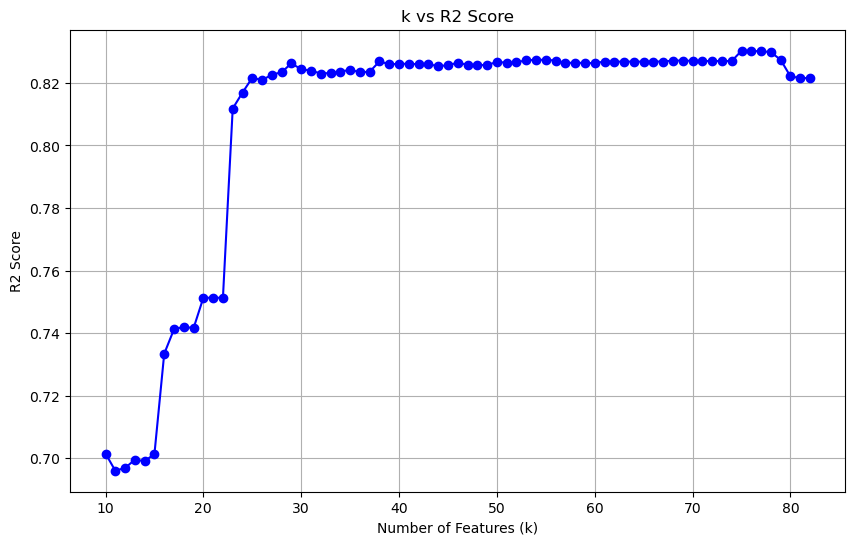

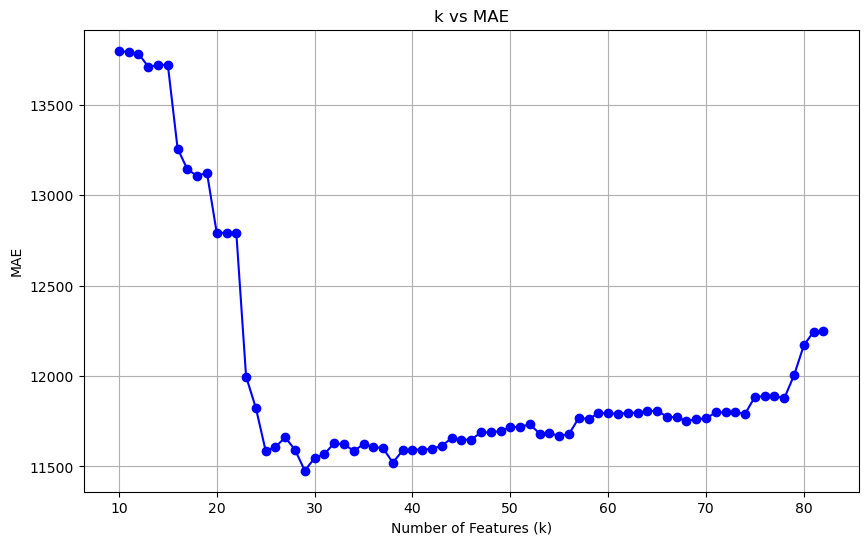

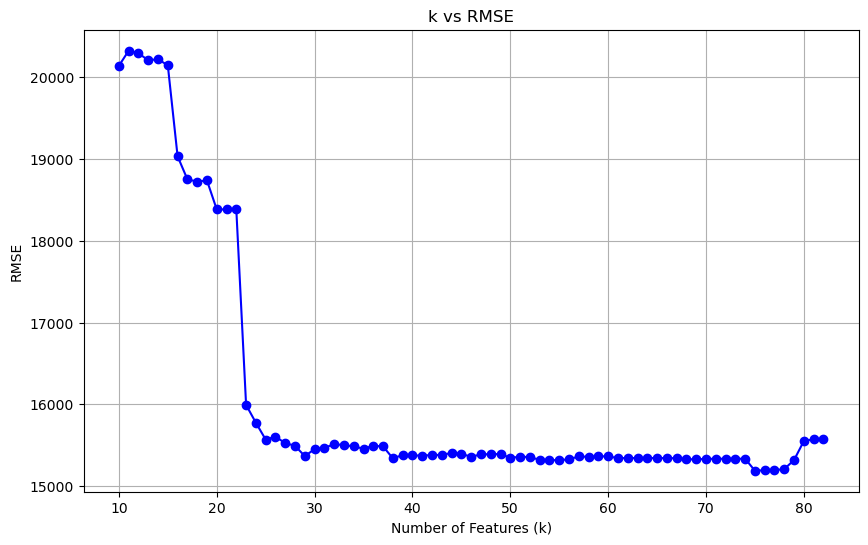

Best R2 k = 75, Best MAE k = 29


In [36]:
model = LinearRegression()
k_values = list(range(10, 83))

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=2)

train_df = pd.DataFrame(X_train)
train_df['y'] = y_train

correlation_matrix = train_df.corr()
correlation_with_target = correlation_matrix['y'].drop(labels=['y']).abs()

sorted_features = correlation_with_target.sort_values(ascending=False)

r2_scores = []
mae_val = []
RMSE_val = []

for k in k_values:
    top_k_features = sorted_features.head(k).index.tolist()

    X_train_selected = X_train[top_k_features]
    X_val_selected = X_val[top_k_features]

    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_val_selected)
    r2_scores.append(r2_score(y_val, y_pred))
    mae_val.append(mean_absolute_error(y_val, y_pred))
    RMSE_val.append(mean_squared_error(y_val, y_pred,squared= False))

plt.figure(figsize=(10, 6))
plt.plot(k_values, r2_scores, marker='o', linestyle='-', color='b')
plt.title('k vs R2 Score')
plt.xlabel('Number of Features (k)')
plt.ylabel('R2 Score')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(k_values, mae_val, marker='o', linestyle='-', color='b')
plt.title('k vs MAE')
plt.xlabel('Number of Features (k)')
plt.ylabel('MAE')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(k_values, RMSE_val, marker='o', linestyle='-', color='b')
plt.title('k vs RMSE')
plt.xlabel('Number of Features (k)')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()

r2_k = 10 + r2_scores.index(max(r2_scores))
mae_k = 10+ mae_val.index(min(mae_val))
print(f"Best R2 k = {r2_k}, Best MAE k = {mae_k}")

In [37]:
X = df_prep.drop(columns=['Price'])
y = df_prep['Price']
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')

#r2_k
print(f"Using k = {r2_k} best features")
selected_feature_names = sorted_features.head(r2_k).index.tolist()
X_SF = X[selected_feature_names]
X_train_SF, X_val_SF, y_train, y_val = train_test_split(X_SF, y, test_size=0.15,random_state=2)

model = LinearRegression()

model.fit(X_train_SF, y_train)

y_pred = model.predict(X_val_SF)

print("\nValidation Scores")
print('R2 score:', r2_score(y_val, y_pred))
print('MAE:', mean_absolute_error(y_val, y_pred))
print('RMSE:', mean_squared_error(y_val, y_pred, squared= False))

X_test_SF = X_test[selected_feature_names]
y_test_pred_SF = model.predict(X_test_SF)

# Calculate and print the R2 score and MAE
# print("\nTest Scores")
# print('R2 score:', r2_score(y_test, y_test_pred_SF))
# print('MAE:', mean_absolute_error(y_test, y_test_pred_SF))
# print('RMSE:', mean_squared_error(y_test, y_test_pred_SF, squared= False))

Using k = 75 best features

Validation Scores
R2 score: 0.8302582749091988
MAE: 11885.544981852297
RMSE: 15187.876731446704


In [38]:
X = df_prep.drop(columns=['Price'])
y = df_prep['Price']
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')
feature_names = list(X.columns)

#mae_k
print(f"Using k = {mae_k} best features")
selected_feature_names = sorted_features.head(mae_k).index.tolist()
X_SF = X[selected_feature_names]
X_train_SF, X_val_SF, y_train, y_val = train_test_split(X_SF, y, test_size=0.15,random_state=2)

model = LinearRegression()

model.fit(X_train_SF, y_train)

y_pred = model.predict(X_val_SF)

print("\nValidation Scores")
print('R2 score:', r2_score(y_val, y_pred))
print('MAE:', mean_absolute_error(y_val, y_pred))
print('RMSE:', mean_squared_error(y_val, y_pred, squared= False))

X_test_SF = X_test[selected_feature_names]
y_test_pred_SF = model.predict(X_test_SF)

# Calculate and print the R2 score and MAE
# print("\nTest Scores")
# print('R2 score:', r2_score(y_test, y_test_pred_SF))
# print('MAE:', mean_absolute_error(y_test, y_test_pred_SF))
# print('RMSE:', mean_squared_error(y_test, y_test_pred_SF, squared= False))

Using k = 29 best features

Validation Scores
R2 score: 0.8262399088606198
MAE: 11476.578414040363
RMSE: 15366.59961647379


2. Backward sequential feature selection

In [39]:
def backward_sequential_feature_selection(model, X_train, X_val, y_train, y_val, features):
    selected_features = features.copy()
    best_features = features.copy()
    best_score = -np.inf
    
    while len(selected_features) > 1: 
        scores = []
        for feature in selected_features:
            remaining_features = [f for f in selected_features if f != feature]
            model.fit(X_train[remaining_features], y_train)

            y_pred = model.predict(X_val[remaining_features])

            score = r2_score(y_val, y_pred)  
            scores.append((feature, score))
        

        worst_feature, worst_score = min(scores, key=lambda x: x[1])
        

        if worst_score > best_score:
            best_score = worst_score
            best_features.remove(worst_feature)
        else:

            break
    
    return best_features, best_score


model = LinearRegression()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=2)

features = X_train.columns.tolist()

selected_features, best_score = backward_sequential_feature_selection(model, X_train,\
                                                    X_val, y_train, y_val, features)

print("Best features selected:", selected_features)
print("Best R2 score:", best_score)


Best features selected: ['Company_Apple', 'Company_Asus', 'Company_Chuwi', 'Company_Dell', 'Company_Fujitsu', 'Company_Google', 'Company_HP', 'Company_Huawei', 'Company_LG', 'Company_Lenovo', 'Company_MSI', 'Company_Mediacom', 'Company_Microsoft', 'Company_Razer', 'Company_Samsung', 'Company_Toshiba', 'Company_Vero', 'Company_Xiaomi', 'TypeName_Gaming', 'TypeName_Netbook', 'TypeName_Notebook', 'TypeName_Ultrabook', 'TypeName_Workstation', 'OpSys_Chrome OS', 'OpSys_Linux', 'OpSys_Mac OS X', 'OpSys_No OS', 'OpSys_Windows 10', 'OpSys_Windows 10 S', 'OpSys_Windows 7', 'OpSys_macOS', 'cpu_brand_Intel', 'cpu_model_1700', 'cpu_model_6110', 'cpu_model_7110', 'cpu_model_7210', 'cpu_model_7310', 'cpu_model_7410', 'cpu_model_8800P', 'cpu_model_9000', 'cpu_model_9000e', 'cpu_model_9220', 'cpu_model_9410', 'cpu_model_9420', 'cpu_model_9600P', 'cpu_model_9620P', 'cpu_model_9700P', 'cpu_model_9720P', 'cpu_model_9830P', 'cpu_model_A10-9620P', 'cpu_model_A6-9220', 'cpu_model_A9-9420', 'cpu_model_Dual',

All this methods were without standardization.

Now we will do "Standardization + feature selection"

In [40]:
# features_to_standardize = features = ['Inches', 'Ram', 'Weight', 'cpu_speed', 'resolution_width', 'resolution_height', 'ssd_capacity_gb', 'hdd_capacity_gb', 'flash_storage_capacity_gb', 'total_storage_gb']

In [41]:
# df_final_standardized = df_final
# # Extract the features for standardization
# X = df_final_standardized[features_to_standardize]

# # Initialize the StandardScaler
# scaler = StandardScaler()

# # Fit the scaler to your data and transform it
# X_standardized = scaler.fit_transform(X)

# # Replace original data with standardized data
# df_final_standardized[features_to_standardize] = X_standardized

# # Your dataset is now standardized and ready for machine learning algorithms
# # print(df_final_standardized.head())

In [42]:
# X = df_final_standardized.drop(columns=['Price'])
# y = df_final['Price']
# # Split your dataset into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=2)

# # Convert X_train and y_train to DataFrame for correlation calculation
# train_df = pd.DataFrame(X_train)
# train_df['y'] = y_train

# # Calculate Pearson correlation coefficients
# correlation_matrix = train_df.corr()
# correlation_with_target = correlation_matrix['y'].drop(labels=['y']).abs()

# # Sort features based on correlation
# sorted_features = correlation_with_target.sort_values(ascending=False)


In [43]:
# r2_scores = []

# # Iterate over the range of k values
# for k in range(10, 83):
#     # Select the top k features based on their correlation values
#     top_k_features = sorted_features.head(k).index.tolist()

#     # Select these top k features from the training and validation sets
#     X_train_selected = X_train[top_k_features]
#     X_val_selected = X_val[top_k_features]

#     # Train the Linear Regression model
#     model = LinearRegression()
#     model.fit(X_train_selected, y_train)

#     # Predict on the validation set
#     y_pred = model.predict(X_val_selected)

#     # Calculate the R2 score and append it to the list
#     r2 = r2_score(y_val, y_pred)
#     r2_scores.append(r2)

# # Plotting the results
# plt.figure(figsize=(10, 6))
# plt.plot(range(10, 83), r2_scores, marker='o', linestyle='-', color='b')
# plt.title('Number of Features vs. R2 Score')
# plt.xlabel('Number of Features (k)')
# plt.ylabel('R2 Score')
# plt.grid(True)
# plt.show()

In [44]:
# # X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=2)
# # # Lets take k= 68
# top_k_features = sorted_features.head(53).index.tolist()

# # Select these top k features from the training and validation sets
# X_train_selected = X_train[top_k_features]
# X_val_selected = X_val[top_k_features]

# # Train the Linear Regression model
# model = LinearRegression()
# model.fit(X_train_selected, y_train)

# # Predict on the validation set
# y_pred = model.predict(X_val_selected)

# # Calculate the R2 score and append it to the list
# print("R2_Score:", r2_score(y_val, y_pred))

In [45]:
# top_k_features_standardized_FS = sorted_features.head(55).index.tolist()

# # Select these top k features from the training and validation sets
# X_train_selected = X_train[top_k_features_standardized_FS]
# X_val_selected = X_val[top_k_features_standardized_FS]

# # Train the Linear Regression model
# model = LinearRegression()
# model.fit(X_train_selected, y_train)

# # Predict on the validation set
# y_pred = model.predict(X_val_selected)

# # Calculate the R2 score and append it to the list
# print("R2_Score:", r2_score(y_val, y_pred))

In [46]:
# top_k_features_standardized_FS = sorted_features.head(47).index.tolist()

# # Select these top k features from the training and validation sets
# X_train_selected = X_train[top_k_features_standardized_FS]
# X_val_selected = X_val[top_k_features_standardized_FS]

# # Train the Linear Regression model
# model = LinearRegression()
# model.fit(X_train_selected, y_train)

# # Predict on the validation set
# y_pred = model.predict(X_val_selected)

# # Calculate the R2 score and append it to the list
# print("R2_Score:", r2_score(y_val, y_pred))

I will move ahead without standadization. As mentioned in report, that we tried standardization and validation score changes were very negligible and for models it was decreasing. 

### Training on different Models apart from Baseline model and Trivial

#### 1. Lasso Regression

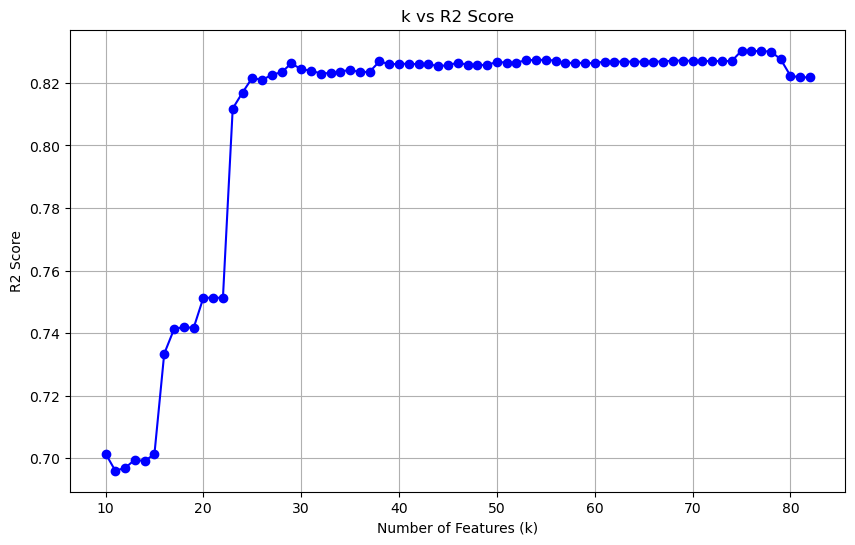

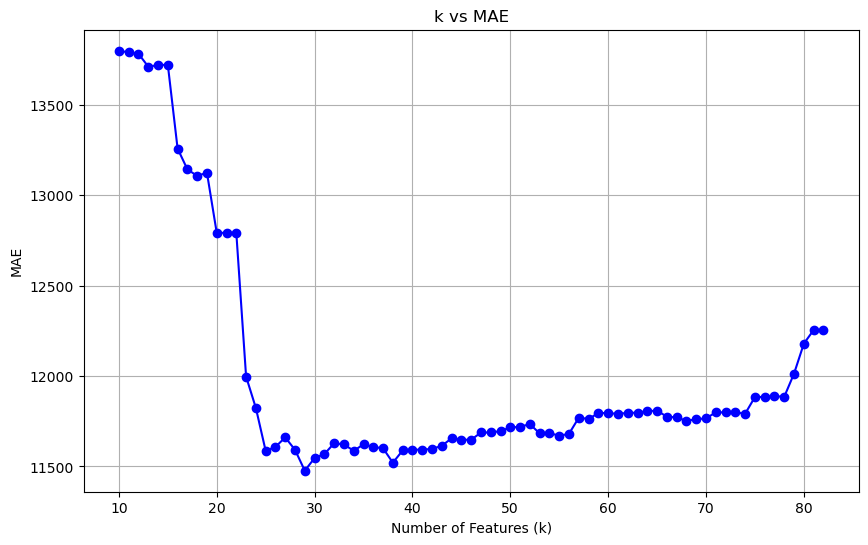

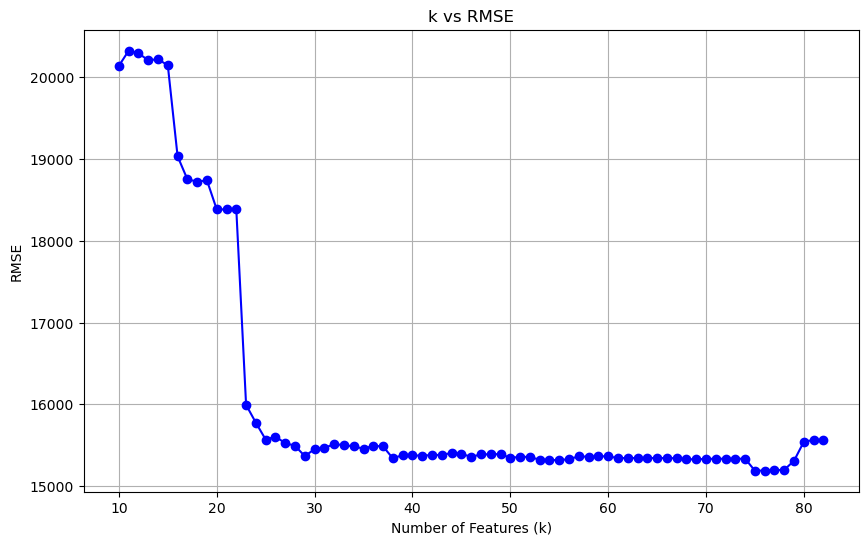

Best R2 k = 75, Best MAE k = 29


In [47]:
X = df_prep.drop(columns=['Price'])
y = df_prep['Price']
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')
model = Lasso(alpha=0.0005)
k_values = list(range(10, 83))
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=2)


train_df = pd.DataFrame(X_train)
train_df['y'] = y_train

correlation_matrix = train_df.corr()
correlation_with_target = correlation_matrix['y'].drop(labels=['y']).abs()

sorted_features = correlation_with_target.sort_values(ascending=False)

r2_scores = []
mae_val = []
RMSE_val = []

for k in k_values:
    top_k_features = sorted_features.head(k).index.tolist()

    X_train_selected = X_train[top_k_features]
    X_val_selected = X_val[top_k_features]

    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_val_selected)


    r2_scores.append(r2_score(y_val, y_pred))
    mae_val.append(mean_absolute_error(y_val, y_pred))
    RMSE_val.append(mean_squared_error(y_val, y_pred,squared= False))

plt.figure(figsize=(10, 6))
plt.plot(k_values, r2_scores, marker='o', linestyle='-', color='b')
plt.title('k vs R2 Score')
plt.xlabel('Number of Features (k)')
plt.ylabel('R2 Score')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(k_values, mae_val, marker='o', linestyle='-', color='b')
plt.title('k vs MAE')
plt.xlabel('Number of Features (k)')
plt.ylabel('MAE')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(k_values, RMSE_val, marker='o', linestyle='-', color='b')
plt.title('k vs RMSE')
plt.xlabel('Number of Features (k)')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()

r2_k = 10 + r2_scores.index(max(r2_scores))
mae_k = 10+ mae_val.index(min(mae_val))
print(f"Best R2 k = {r2_k}, Best MAE k = {mae_k}")

In [48]:
X = df_prep.drop(columns=['Price'])
y = df_prep['Price']
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')

#r2_k
print(f"Using k = {r2_k} best features")
selected_feature_names = sorted_features.head(r2_k).index.tolist()
X_SF = X[selected_feature_names]
X_train_SF, X_val_SF, y_train, y_val = train_test_split(X_SF, y, test_size=0.15, random_state=2)

model = Lasso(alpha=0.0005)

model.fit(X_train_SF, y_train)

y_pred = model.predict(X_val_SF)

print("\nValidation Scores")
print('R2 score:', r2_score(y_val, y_pred))
print('MAE:', mean_absolute_error(y_val, y_pred))
print('RMSE:', mean_squared_error(y_val, y_pred, squared= False))

# X_test_SF = X_test[selected_feature_names]
# y_test_pred_SF = model.predict(X_test_SF)

# # Calculate and print the R2 score and MAE
# print("\nTest Scores")
# print('R2 score:', r2_score(y_test, y_test_pred_SF))
# print('MAE:', mean_absolute_error(y_test, y_test_pred_SF))
# print('RMSE:', mean_squared_error(y_test, y_test_pred_SF, squared= False))

Using k = 75 best features

Validation Scores
R2 score: 0.8302603737163923
MAE: 11884.29910155775
RMSE: 15187.782834311345


In [49]:
X = df_prep.drop(columns=['Price'])
y = df_prep['Price']
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')

#mae_k
print(f"Using k = {mae_k} best features")
selected_feature_names = sorted_features.head(r2_k).index.tolist()
X_SF = X[selected_feature_names]
X_train_SF, X_val_SF, y_train, y_val = train_test_split(X_SF, y, test_size=0.15,random_state=2)

model = Lasso(alpha=0.0005)

model.fit(X_train_SF, y_train)

y_pred = model.predict(X_val_SF)

print("\nValidation Scores")
print('R2 score:', r2_score(y_val, y_pred))
print('MAE:', mean_absolute_error(y_val, y_pred))
print('RMSE:', mean_squared_error(y_val, y_pred, squared= False))

X_test_SF = X_test[selected_feature_names]
y_test_pred_SF = model.predict(X_test_SF)

# Calculate and print the R2 score and MAE
# print("\nTest Scores")
# print('R2 score:', r2_score(y_test, y_test_pred_SF))
# print('MAE:', mean_absolute_error(y_test, y_test_pred_SF))
# print('RMSE:', mean_squared_error(y_test, y_test_pred_SF, squared= False))

Using k = 29 best features

Validation Scores
R2 score: 0.8302603737163923
MAE: 11884.29910155775
RMSE: 15187.782834311345


#### 2. Ridge regression

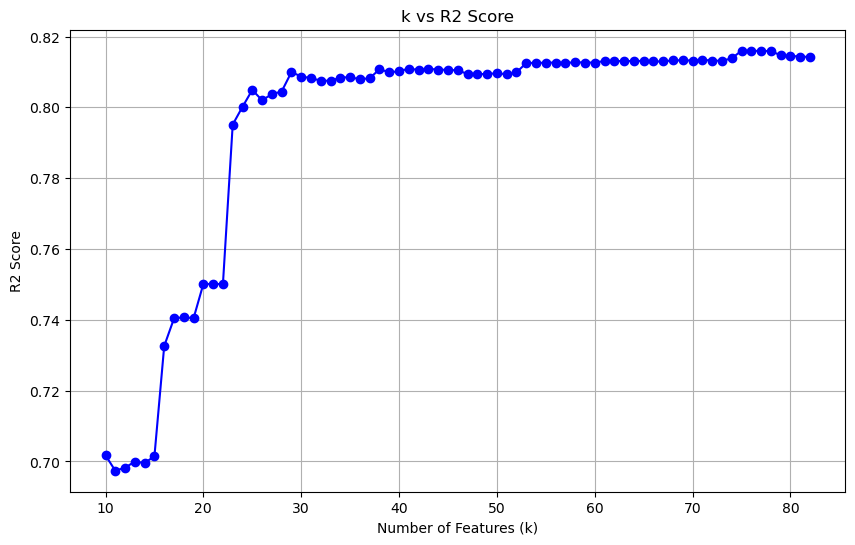

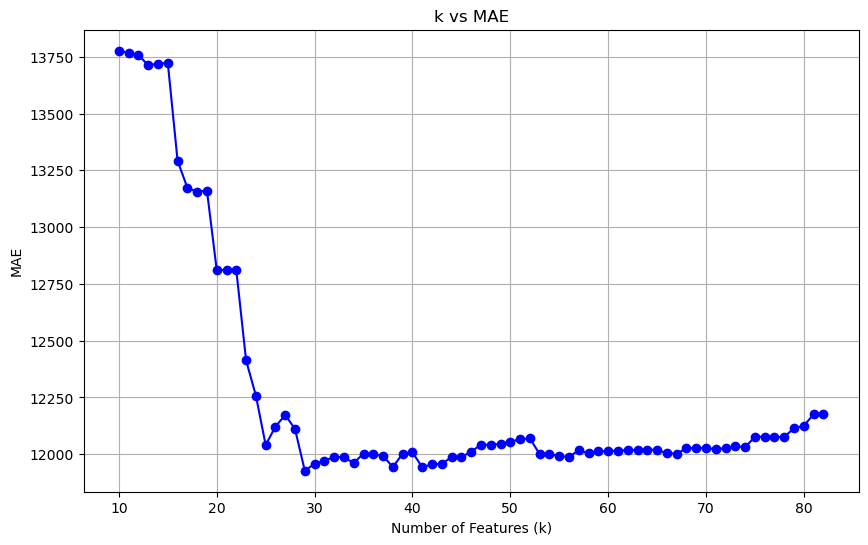

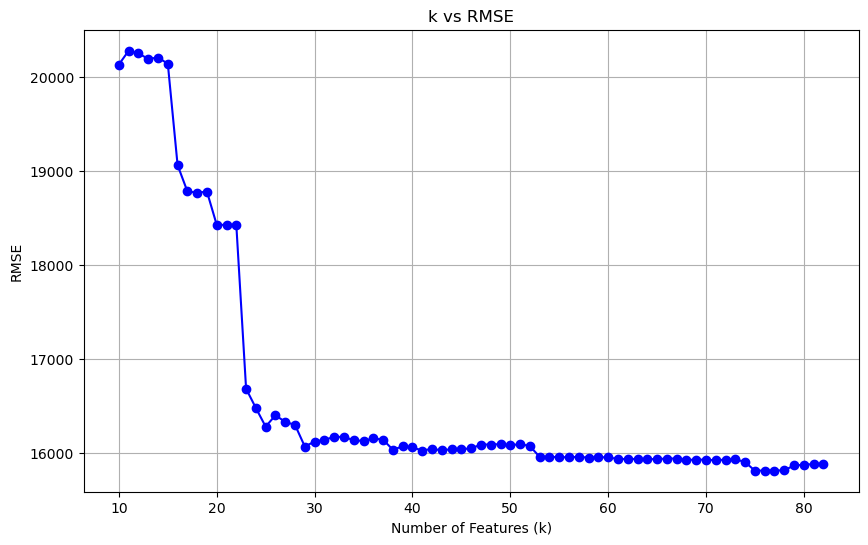

Best R2 k = 75, Best MAE k = 29


In [50]:
X = df_prep.drop(columns=['Price'])
y = df_prep['Price']
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')
model = Ridge()  
k_values = list(range(10, 83))
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=2)


train_df = pd.DataFrame(X_train)
train_df['y'] = y_train

correlation_matrix = train_df.corr()
correlation_with_target = correlation_matrix['y'].drop(labels=['y']).abs()

sorted_features = correlation_with_target.sort_values(ascending=False)

r2_scores = []
mae_val = []
RMSE_val = []

for k in k_values:
    top_k_features = sorted_features.head(k).index.tolist()

    X_train_selected = X_train[top_k_features]
    X_val_selected = X_val[top_k_features]

    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_val_selected)


    r2_scores.append(r2_score(y_val, y_pred))
    mae_val.append(mean_absolute_error(y_val, y_pred))
    RMSE_val.append(mean_squared_error(y_val, y_pred,squared= False))

plt.figure(figsize=(10, 6))
plt.plot(k_values, r2_scores, marker='o', linestyle='-', color='b')
plt.title('k vs R2 Score')
plt.xlabel('Number of Features (k)')
plt.ylabel('R2 Score')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(k_values, mae_val, marker='o', linestyle='-', color='b')
plt.title('k vs MAE')
plt.xlabel('Number of Features (k)')
plt.ylabel('MAE')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(k_values, RMSE_val, marker='o', linestyle='-', color='b')
plt.title('k vs RMSE')
plt.xlabel('Number of Features (k)')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()

r2_k = 10 + r2_scores.index(max(r2_scores))
mae_k = 10+ mae_val.index(min(mae_val))
print(f"Best R2 k = {r2_k}, Best MAE k = {mae_k}")

In [51]:
X = df_prep.drop(columns=['Price'])
y = df_prep['Price']
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')

#r2_k
print(f"Using k = {r2_k} best features")
selected_feature_names = sorted_features.head(r2_k).index.tolist()
X_SF = X[selected_feature_names]
X_train_SF, X_val_SF, y_train, y_val = train_test_split(X_SF, y, test_size=0.15, random_state=2)

model = Ridge()

model.fit(X_train_SF, y_train)

y_pred = model.predict(X_val_SF)

print("\nValidation Scores")
print('R2 score:', r2_score(y_val, y_pred))
print('MAE:', mean_absolute_error(y_val, y_pred))
print('RMSE:', mean_squared_error(y_val, y_pred, squared= False))

X_test_SF = X_test[selected_feature_names]
y_test_pred_SF = model.predict(X_test_SF)

# # Calculate and print the R2 score and MAE
# print("\nTest Scores")
# print('R2 score:', r2_score(y_test, y_test_pred_SF))
# print('MAE:', mean_absolute_error(y_test, y_test_pred_SF))
# print('RMSE:', mean_squared_error(y_test, y_test_pred_SF, squared= False))

Using k = 75 best features

Validation Scores
R2 score: 0.8159867965780756
MAE: 12076.59990902195
RMSE: 15813.47261308166


In [52]:
X = df_prep.drop(columns=['Price'])
y = df_prep['Price']
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')

#mae_k
print(f"Using k = {mae_k} best features")
selected_feature_names = sorted_features.head(r2_k).index.tolist()
X_SF = X[selected_feature_names]
X_train_SF, X_val_SF, y_train, y_val = train_test_split(X_SF, y, test_size=0.15, random_state=2)

model = Ridge()

model.fit(X_train_SF, y_train)

y_pred = model.predict(X_val_SF)

print("\nValidation Scores")
print('R2 score:', r2_score(y_val, y_pred))
print('MAE:', mean_absolute_error(y_val, y_pred))
print('RMSE:', mean_squared_error(y_val, y_pred, squared= False))

X_test_SF = X_test[selected_feature_names]
y_test_pred_SF = model.predict(X_test_SF)

# Calculate and print the R2 score and MAE
# print("\nTest Scores")
# print('R2 score:', r2_score(y_test, y_test_pred_SF))
# print('MAE:', mean_absolute_error(y_test, y_test_pred_SF))
# print('RMSE:', mean_squared_error(y_test, y_test_pred_SF, squared= False))

Using k = 29 best features

Validation Scores
R2 score: 0.8159867965780756
MAE: 12076.59990902195
RMSE: 15813.47261308166


#### 3. Polynomial Regression

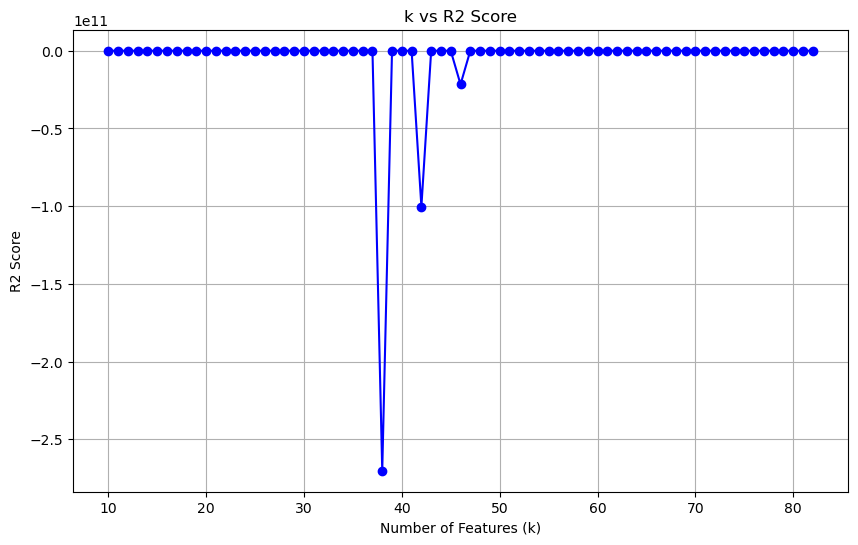

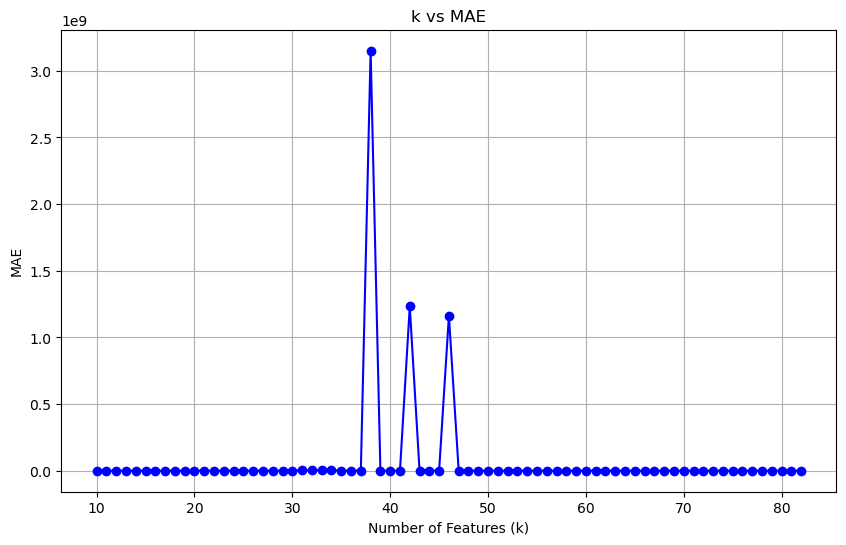

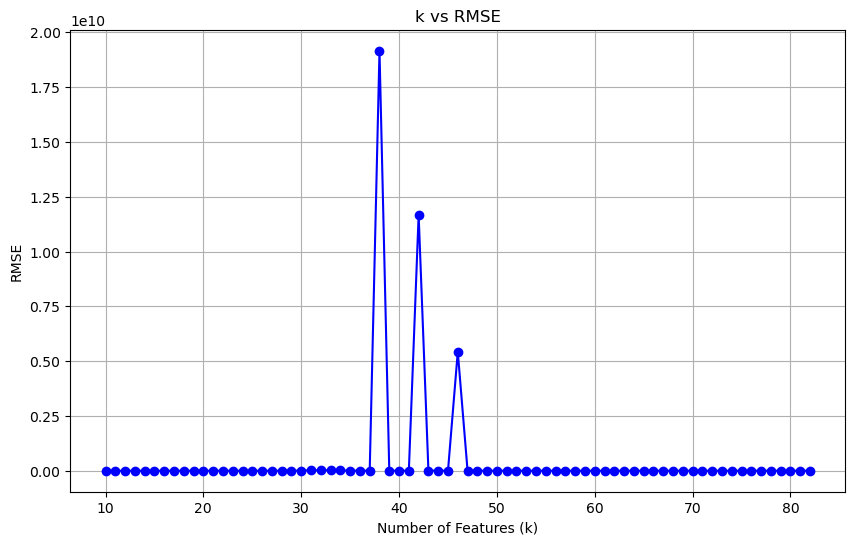

Best R2 k = 12, Best MAE k = 12


In [53]:
X = df_prep.drop(columns=['Price'])
y = df_prep['Price']
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')
model = LinearRegression()
k_values = list(range(10, 83))
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15,random_state=2)


train_df = pd.DataFrame(X_train)
train_df['y'] = y_train

correlation_matrix = train_df.corr()
correlation_with_target = correlation_matrix['y'].drop(labels=['y']).abs()

sorted_features = correlation_with_target.sort_values(ascending=False)

r2_scores = []
mae_val = []
RMSE_val = []

for k in k_values:
    top_k_features = sorted_features.head(k).index.tolist()

    X_train_selected = X_train[top_k_features]
    X_val_selected = X_val[top_k_features]

    poly_transformer = PolynomialFeatures(degree=2)  

    X_train_selected = poly_transformer.fit_transform(X_train_selected)
    X_val_selected = poly_transformer.transform(X_val_selected)

    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_val_selected)


    r2_scores.append(r2_score(y_val, y_pred))
    mae_val.append(mean_absolute_error(y_val, y_pred))
    RMSE_val.append(mean_squared_error(y_val, y_pred,squared= False))

plt.figure(figsize=(10, 6))
plt.plot(k_values, r2_scores, marker='o', linestyle='-', color='b')
plt.title('k vs R2 Score')
plt.xlabel('Number of Features (k)')
plt.ylabel('R2 Score')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(k_values, mae_val, marker='o', linestyle='-', color='b')
plt.title('k vs MAE')
plt.xlabel('Number of Features (k)')
plt.ylabel('MAE')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(k_values, RMSE_val, marker='o', linestyle='-', color='b')
plt.title('k vs RMSE')
plt.xlabel('Number of Features (k)')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()

r2_k = 10 + r2_scores.index(max(r2_scores))
mae_k = 10+ mae_val.index(min(mae_val))
print(f"Best R2 k = {r2_k}, Best MAE k = {mae_k}")

In [54]:
X = df_prep.drop(columns=['Price'])
y = df_prep['Price']
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')

#r2_k
print(f"Using k = {r2_k} best features")
selected_feature_names = sorted_features.head(r2_k).index.tolist()
X_SF = X[selected_feature_names]
X_train_SF, X_val_SF, y_train, y_val = train_test_split(X_SF, y, test_size=0.15, random_state=2)

poly_transformer = PolynomialFeatures(degree=2)  # You can adjust the degree as needed

X_train_SF= poly_transformer.fit_transform(X_train_SF)
X_val_SF = poly_transformer.transform(X_val_SF)
model = LinearRegression()

model.fit(X_train_SF, y_train)

y_pred = model.predict(X_val_SF)

print("\nValidation Scores")
print('R2 score:', r2_score(y_val, y_pred))
print('MAE:', mean_absolute_error(y_val, y_pred))
print('RMSE:', mean_squared_error(y_val, y_pred, squared= False))

X_test_SF = X_test[selected_feature_names]
X_test_SF = poly_transformer.transform(X_test_SF)
y_test_pred_SF = model.predict(X_test_SF)

# Calculate and print the R2 score and MAE
# print("\nTest Scores")
# print('R2 score:', r2_score(y_test, y_test_pred_SF))
# print('MAE:', mean_absolute_error(y_test, y_test_pred_SF))
# print('RMSE:', mean_squared_error(y_test, y_test_pred_SF, squared= False))

Using k = 12 best features

Validation Scores
R2 score: 0.7517659196986123
MAE: 12570.569876281734
RMSE: 18366.798474462317


In [55]:
X = df_prep.drop(columns=['Price'])
y = df_prep['Price']
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')

#mae_k
print(f"Using k = {mae_k} best features")
selected_feature_names = sorted_features.head(r2_k).index.tolist()
X_SF = X[selected_feature_names]
X_train_SF, X_val_SF, y_train, y_val = train_test_split(X_SF, y, test_size=0.15,random_state=2)
poly_transformer = PolynomialFeatures(degree=2)  # You can adjust the degree as needed

X_train_SF= poly_transformer.fit_transform(X_train_SF)
X_val_SF = poly_transformer.transform(X_val_SF)
model = LinearRegression()

model.fit(X_train_SF, y_train)

y_pred = model.predict(X_val_SF)

print("\nValidation Scores")
print('R2 score:', r2_score(y_val, y_pred))
print('MAE:', mean_absolute_error(y_val, y_pred))
print('RMSE:', mean_squared_error(y_val, y_pred, squared= False))

X_test_SF = X_test[selected_feature_names]
X_test_SF = poly_transformer.transform(X_test_SF)
y_test_pred_SF = model.predict(X_test_SF)

# Calculate and print the R2 score and MAE
# print("\nTest Scores")
# print('R2 score:', r2_score(y_test, y_test_pred_SF))
# print('MAE:', mean_absolute_error(y_test, y_test_pred_SF))
# print('RMSE:', mean_squared_error(y_test, y_test_pred_SF, squared= False))

Using k = 12 best features

Validation Scores
R2 score: 0.7517659196986123
MAE: 12570.569876281734
RMSE: 18366.798474462317


4. SVR

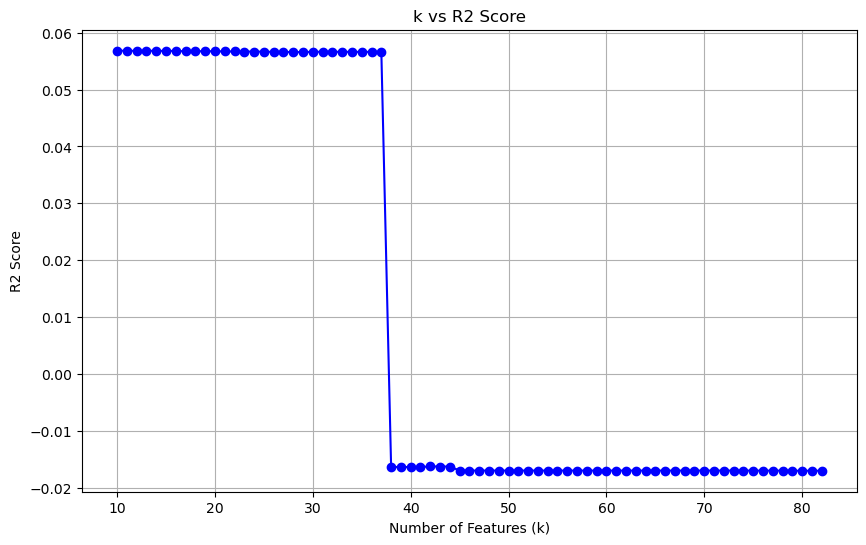

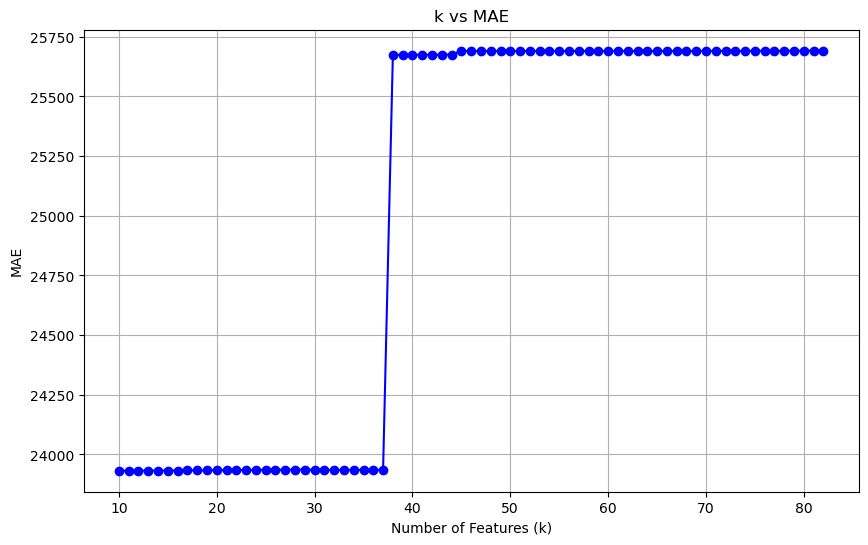

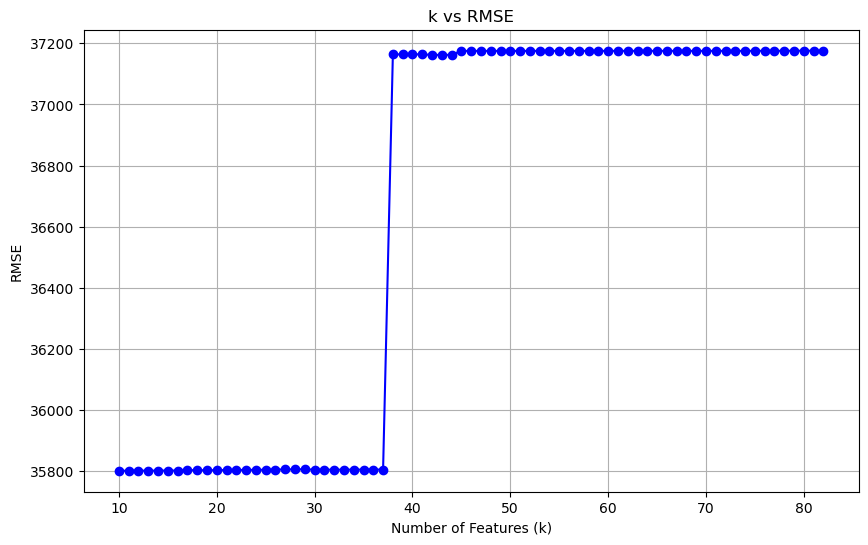

Best R2 k = 10, Best MAE k = 10


In [56]:
X = df_prep.drop(columns=['Price'])
y = df_prep['Price']
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')
model = SVR(kernel='rbf', C=100.0, epsilon=0.12, gamma=0.001)  
k_values = list(range(10, 83))
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=2)


train_df = pd.DataFrame(X_train)
train_df['y'] = y_train

correlation_matrix = train_df.corr()
correlation_with_target = correlation_matrix['y'].drop(labels=['y']).abs()

sorted_features = correlation_with_target.sort_values(ascending=False)

r2_scores = []
mae_val = []
RMSE_val = []

for k in k_values:
    top_k_features = sorted_features.head(k).index.tolist()

    X_train_selected = X_train[top_k_features]
    X_val_selected = X_val[top_k_features]

    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_val_selected)


    r2_scores.append(r2_score(y_val, y_pred))
    mae_val.append(mean_absolute_error(y_val, y_pred))
    RMSE_val.append(mean_squared_error(y_val, y_pred,squared= False))

plt.figure(figsize=(10, 6))
plt.plot(k_values, r2_scores, marker='o', linestyle='-', color='b')
plt.title('k vs R2 Score')
plt.xlabel('Number of Features (k)')
plt.ylabel('R2 Score')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(k_values, mae_val, marker='o', linestyle='-', color='b')
plt.title('k vs MAE')
plt.xlabel('Number of Features (k)')
plt.ylabel('MAE')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(k_values, RMSE_val, marker='o', linestyle='-', color='b')
plt.title('k vs RMSE')
plt.xlabel('Number of Features (k)')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()

r2_k = 10 + r2_scores.index(max(r2_scores))
mae_k = 10+ mae_val.index(min(mae_val))
print(f"Best R2 k = {r2_k}, Best MAE k = {mae_k}")

In [57]:
X = df_prep.drop(columns=['Price'])
y = df_prep['Price']
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')

#mae_k
print(f"Using k = {mae_k} best features")
selected_feature_names = sorted_features.head(r2_k).index.tolist()
X_SF = X[selected_feature_names]
X_train_SF, X_val_SF, y_train, y_val = train_test_split(X_SF, y, test_size=0.15,random_state=2)

model = SVR(kernel='rbf', C=100.0, epsilon=0.12, gamma=0.001) 

model.fit(X_train_SF, y_train)

y_pred = model.predict(X_val_SF)

print("\nValidation Scores")
print('R2 score:', r2_score(y_val, y_pred))
print('MAE:', mean_absolute_error(y_val, y_pred))
print('RMSE:', mean_squared_error(y_val, y_pred, squared= False))

X_test_SF = X_test[selected_feature_names]
y_test_pred_SF = model.predict(X_test_SF)

# Calculate and print the R2 score and MAE
# print("\nTest Scores")
# print('R2 score:', r2_score(y_test, y_test_pred_SF))
# print('MAE:', mean_absolute_error(y_test, y_test_pred_SF))
# print('RMSE:', mean_squared_error(y_test, y_test_pred_SF, squared= False))

Using k = 10 best features

Validation Scores
R2 score: 0.056815021478725636
MAE: 23931.99288667501
RMSE: 35801.49774022845


In [58]:
X = df_prep.drop(columns=['Price'])
y = df_prep['Price']
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')

#r2_k
print(f"Using k = {r2_k} best features")
selected_feature_names = sorted_features.head(r2_k).index.tolist()
X_SF = X[selected_feature_names]
X_train_SF, X_val_SF, y_train, y_val = train_test_split(X_SF, y, test_size=0.15,random_state=2)

model = SVR(kernel='rbf', C=100.0, epsilon=0.12, gamma=0.001) 

model.fit(X_train_SF, y_train)

y_pred = model.predict(X_val_SF)

print("\nValidation Scores")
print('R2 score:', r2_score(y_val, y_pred))
print('MAE:', mean_absolute_error(y_val, y_pred))
print('RMSE:', mean_squared_error(y_val, y_pred, squared= False))

X_test_SF = X_test[selected_feature_names]
y_test_pred_SF = model.predict(X_test_SF)

# Calculate and print the R2 score and MAE
# print("\nTest Scores")
# print('R2 score:', r2_score(y_test, y_test_pred_SF))
# print('MAE:', mean_absolute_error(y_test, y_test_pred_SF))
# print('RMSE:', mean_squared_error(y_test, y_test_pred_SF, squared= False))

Using k = 10 best features

Validation Scores
R2 score: 0.056815021478725636
MAE: 23931.99288667501
RMSE: 35801.49774022845


5. SVR + Linear

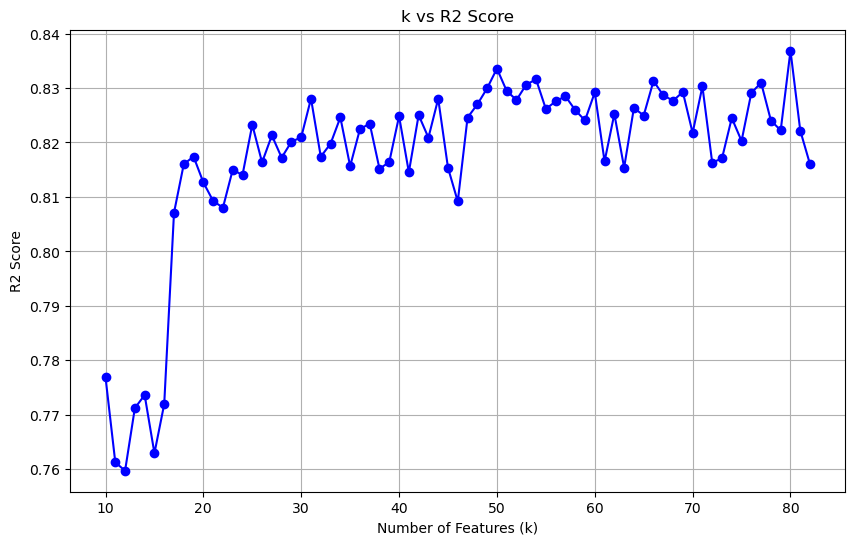

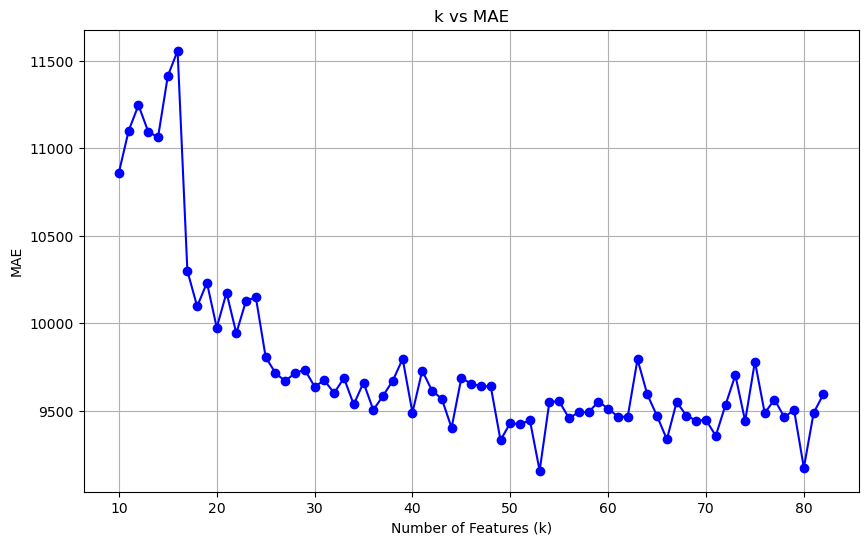

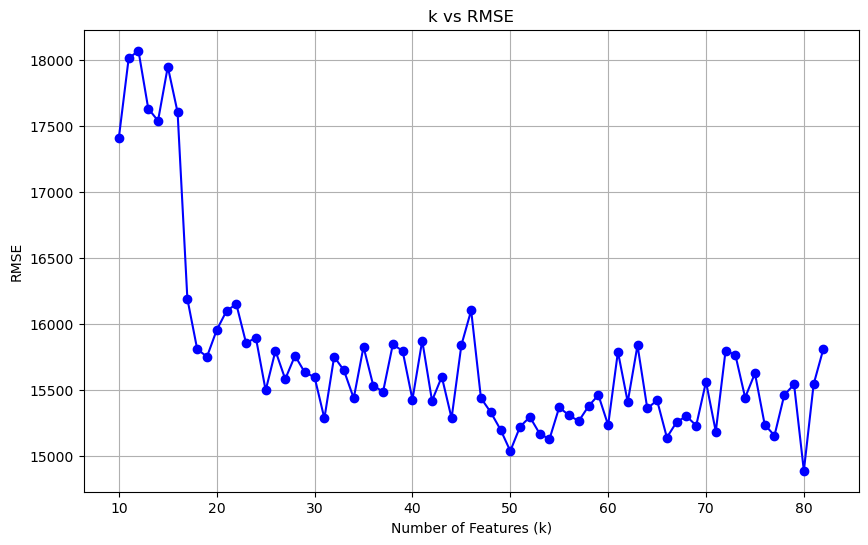

Best R2 k = 80, Best MAE k = 53


In [59]:
# for validation
X = df_prep.drop(columns=['Price'])
y = df_prep['Price']
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')
svr = SVR(kernel='rbf', C=100.0, epsilon=0.12, gamma=0.001)
rf = RandomForestRegressor(n_estimators=100)

linear_model = LinearRegression()
model = StackingRegressor(
    estimators=[('svr', svr), ('rf', rf)],
    final_estimator=linear_model
)
k_values = list(range(10, 83))
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15,random_state=2)


train_df = pd.DataFrame(X_train)
train_df['y'] = y_train

correlation_matrix = train_df.corr()
correlation_with_target = correlation_matrix['y'].drop(labels=['y']).abs()

sorted_features = correlation_with_target.sort_values(ascending=False)

r2_scores = []
mae_val = []
RMSE_val = []

for k in k_values:
    top_k_features = sorted_features.head(k).index.tolist()

    X_train_selected = X_train[top_k_features]
    X_val_selected = X_val[top_k_features]

    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_val_selected)


    r2_scores.append(r2_score(y_val, y_pred))
    mae_val.append(mean_absolute_error(y_val, y_pred))
    RMSE_val.append(mean_squared_error(y_val, y_pred,squared= False))

plt.figure(figsize=(10, 6))
plt.plot(k_values, r2_scores, marker='o', linestyle='-', color='b')
plt.title('k vs R2 Score')
plt.xlabel('Number of Features (k)')
plt.ylabel('R2 Score')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(k_values, mae_val, marker='o', linestyle='-', color='b')
plt.title('k vs MAE')
plt.xlabel('Number of Features (k)')
plt.ylabel('MAE')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(k_values, RMSE_val, marker='o', linestyle='-', color='b')
plt.title('k vs RMSE')
plt.xlabel('Number of Features (k)')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()

r2_k = 10 + r2_scores.index(max(r2_scores))
mae_k = 10+ mae_val.index(min(mae_val))
print(f"Best R2 k = {r2_k}, Best MAE k = {mae_k}")

In [60]:
X = df_prep.drop(columns=['Price'])
y = df_prep['Price']
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')
X_test = df_test_prep.drop(columns=['Price'])
y_test = df_test_prep['Price']
#r2_k
print(f"Using k = {r2_k} best features")
selected_feature_names = sorted_features.head(r2_k).index.tolist()
X_SF = X[selected_feature_names]
svr = SVR(kernel='rbf', C=100.0, epsilon=0.12, gamma=0.001)
rf = RandomForestRegressor(n_estimators=100)

linear_model = LinearRegression()
model = StackingRegressor(
    estimators=[('svr', svr), ('rf', rf)],
    final_estimator=linear_model
) 

model.fit(X_SF,y)

kf = KFold(n_splits=10, shuffle=True, random_state=42)
r2_scores = cross_val_score(model,X_SF,y,cv=kf,scoring='r2')
r2_score_val = mean(r2_scores)

mae_scores = cross_val_score(model,X_SF,y,cv=kf,scoring='neg_mean_absolute_error')
mae_score = -mean(mae_scores)

rmse_scores = cross_val_score(model,X_SF,y,cv=kf,scoring='neg_root_mean_squared_error')
rmse_score = -mean(rmse_scores)
print("Average Validation Scores")
print('R2 score:', r2_score_val)
print('MAE:', mae_score)
print('RMSE:', rmse_score)
# X_train_SF, X_val_SF, y_train, y_val = train_test_split(X_SF, y, test_size=0.15, random_state=2)

# model.fit(X_train_SF, y_train)

# y_pred = model.predict(X_val_SF)

# print("\nValidation Scores")
# print('R2 score:', r2_score(y_val, y_pred))
# print('MAE:', mean_absolute_error(y_val, y_pred))
# print('RMSE:', mean_squared_error(y_val, y_pred, squared= False))

X_test_SF = X_test[selected_feature_names]
y_test_pred_SF = model.predict(X_test_SF)

print("\nTest Scores")
print('R2 score:', r2_score(y_test, y_test_pred_SF))
print('MAE:', mean_absolute_error(y_test, y_test_pred_SF))
print('RMSE:', mean_squared_error(y_test, y_test_pred_SF, squared= False))

Using k = 80 best features
Average Validation Scores
R2 score: 0.9050574702750609
MAE: 8170.160974476795
RMSE: 11309.139397118372

Test Scores
R2 score: 0.7586076247015442
MAE: 11336.569299622992
RMSE: 17615.920499191157


In [61]:
X = df_prep.drop(columns=['Price'])
y = df_prep['Price']
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')

#mae_k
print(f"Using k = {mae_k} best features")
selected_feature_names = sorted_features.head(r2_k).index.tolist()
X_SF = X[selected_feature_names]
X_train_SF, X_val_SF, y_train, y_val = train_test_split(X_SF, y, test_size=0.15,random_state=2)

model = StackingRegressor(
    estimators=[('svr', svr), ('rf', rf)],
    final_estimator=linear_model
) 

model.fit(X_train_SF, y_train)

y_pred = model.predict(X_val_SF)

print("\nValidation Scores")
print('R2 score:', r2_score(y_val, y_pred))
print('MAE:', mean_absolute_error(y_val, y_pred))
print('RMSE:', mean_squared_error(y_val, y_pred, squared= False))

X_test_SF = X_test[selected_feature_names]
y_test_pred_SF = model.predict(X_test_SF)

print("\nTest Scores")
print('R2 score:', r2_score(y_test, y_test_pred_SF))
print('MAE:', mean_absolute_error(y_test, y_test_pred_SF))
print('RMSE:', mean_squared_error(y_test, y_test_pred_SF, squared= False))

Using k = 53 best features

Validation Scores
R2 score: 0.8270769931354762
MAE: 9481.453319184822
RMSE: 15329.540852886868

Test Scores
R2 score: 0.7518712095367779
MAE: 11283.239643040153
RMSE: 17860.02846881248


6. probabilistic

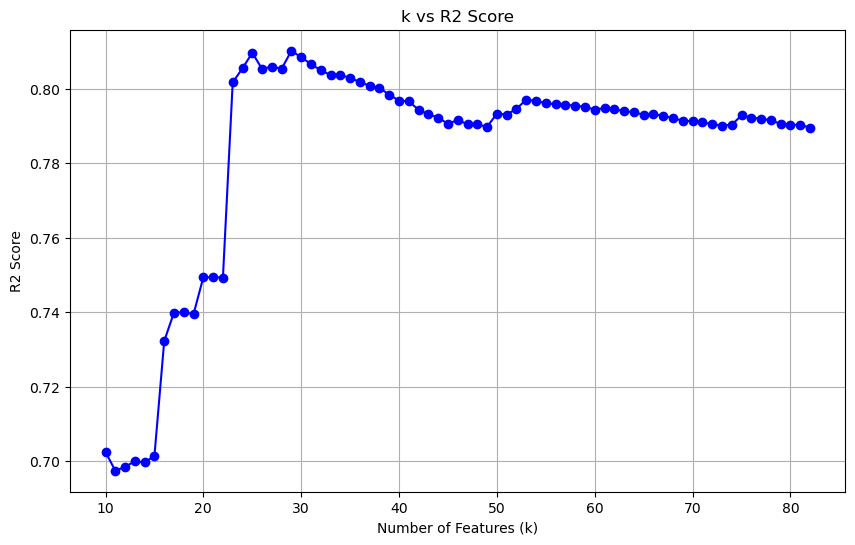

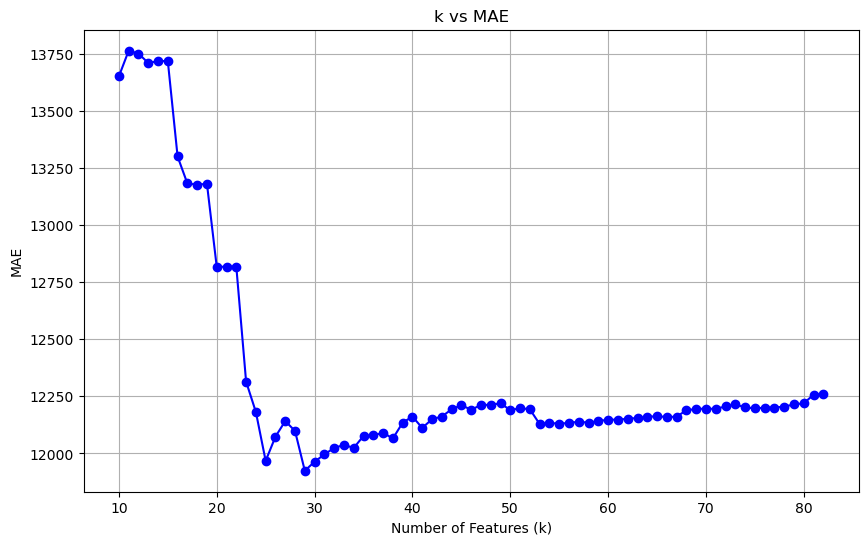

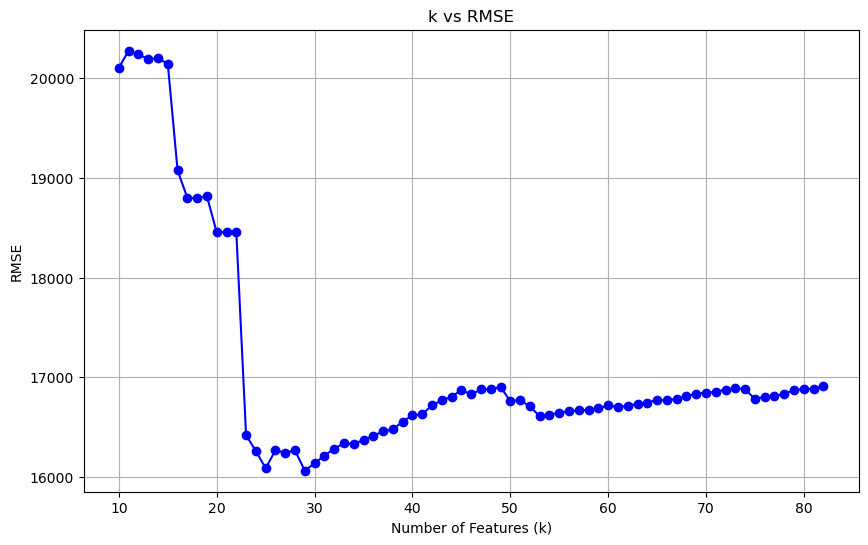

Best R2 k = 29, Best MAE k = 29


In [62]:
X = df_prep.drop(columns=['Price'])
y = df_prep['Price']
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')
model = BayesianRidge()  
k_values = list(range(10, 83))
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15,random_state=2)


train_df = pd.DataFrame(X_train)
train_df['y'] = y_train

correlation_matrix = train_df.corr()
correlation_with_target = correlation_matrix['y'].drop(labels=['y']).abs()

sorted_features = correlation_with_target.sort_values(ascending=False)

r2_scores = []
mae_val = []
RMSE_val = []

for k in k_values:
    top_k_features = sorted_features.head(k).index.tolist()

    X_train_selected = X_train[top_k_features]
    X_val_selected = X_val[top_k_features]

    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_val_selected)


    r2_scores.append(r2_score(y_val, y_pred))
    mae_val.append(mean_absolute_error(y_val, y_pred))
    RMSE_val.append(mean_squared_error(y_val, y_pred,squared= False))

plt.figure(figsize=(10, 6))
plt.plot(k_values, r2_scores, marker='o', linestyle='-', color='b')
plt.title('k vs R2 Score')
plt.xlabel('Number of Features (k)')
plt.ylabel('R2 Score')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(k_values, mae_val, marker='o', linestyle='-', color='b')
plt.title('k vs MAE')
plt.xlabel('Number of Features (k)')
plt.ylabel('MAE')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(k_values, RMSE_val, marker='o', linestyle='-', color='b')
plt.title('k vs RMSE')
plt.xlabel('Number of Features (k)')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()

r2_k = 10 + r2_scores.index(max(r2_scores))
mae_k = 10+ mae_val.index(min(mae_val))
print(f"Best R2 k = {r2_k}, Best MAE k = {mae_k}")

In [63]:
X = df_prep.drop(columns=['Price'])
y = df_prep['Price']
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')

#r2_k
print(f"Using k = {r2_k} best features")
selected_feature_names = sorted_features.head(r2_k).index.tolist()
X_SF = X[selected_feature_names]
X_train_SF, X_val_SF, y_train, y_val = train_test_split(X_SF, y, test_size=0.15,  random_state=2)

model = BayesianRidge()

model.fit(X_train_SF, y_train)

y_pred = model.predict(X_val_SF)

print("\nValidation Scores")
print('R2 score:', r2_score(y_val, y_pred))
print('MAE:', mean_absolute_error(y_val, y_pred))
print('RMSE:', mean_squared_error(y_val, y_pred, squared= False))

X_test_SF = X_test[selected_feature_names]
y_test_pred_SF = model.predict(X_test_SF)

# Calculate and print the R2 score and MAE
# print("\nTest Scores")
# print('R2 score:', r2_score(y_test, y_test_pred_SF))
# print('MAE:', mean_absolute_error(y_test, y_test_pred_SF))
# print('RMSE:', mean_squared_error(y_test, y_test_pred_SF, squared= False))

Using k = 29 best features

Validation Scores
R2 score: 0.810148059134546
MAE: 11924.225434600929
RMSE: 16062.394141664927


In [64]:
X = df_prep.drop(columns=['Price'])
y = df_prep['Price']
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')

#mae_k
print(f"Using k = {mae_k} best features")
selected_feature_names = sorted_features.head(r2_k).index.tolist()
X_SF = X[selected_feature_names]
X_train_SF, X_val_SF, y_train, y_val = train_test_split(X_SF, y, test_size=0.15,random_state=2)

model = BayesianRidge()

model.fit(X_train_SF, y_train)

y_pred = model.predict(X_val_SF)

print("\nValidation Scores")
print('R2 score:', r2_score(y_val, y_pred))
print('MAE:', mean_absolute_error(y_val, y_pred))
print('RMSE:', mean_squared_error(y_val, y_pred, squared= False))

X_test_SF = X_test[selected_feature_names]
y_test_pred_SF = model.predict(X_test_SF)

# Calculate and print the R2 score and MAE
# print("\nTest Scores")
# print('R2 score:', r2_score(y_test, y_test_pred_SF))
# print('MAE:', mean_absolute_error(y_test, y_test_pred_SF))
# print('RMSE:', mean_squared_error(y_test, y_test_pred_SF, squared= False))

Using k = 29 best features

Validation Scores
R2 score: 0.810148059134546
MAE: 11924.225434600929
RMSE: 16062.394141664927


7. Artificial Neural Network 

Epoch [10/1000], MSE Loss: 0.1954,        RMSE Loss: 0.4421, R2 Score: 0.4190
Epoch [20/1000], MSE Loss: 0.1418,        RMSE Loss: 0.3766, R2 Score: 0.7555
Epoch [30/1000], MSE Loss: 0.1172,        RMSE Loss: 0.3424, R2 Score: 0.8554
Epoch [40/1000], MSE Loss: 0.1000,        RMSE Loss: 0.3163, R2 Score: 0.8960
Epoch [50/1000], MSE Loss: 0.0946,        RMSE Loss: 0.3075, R2 Score: 0.9025
Epoch [60/1000], MSE Loss: 0.0902,        RMSE Loss: 0.3004, R2 Score: 0.9049
Epoch [70/1000], MSE Loss: 0.0871,        RMSE Loss: 0.2952, R2 Score: 0.9041
Epoch [80/1000], MSE Loss: 0.0787,        RMSE Loss: 0.2806, R2 Score: 0.9044
Epoch [90/1000], MSE Loss: 0.0753,        RMSE Loss: 0.2745, R2 Score: 0.9092
Epoch [100/1000], MSE Loss: 0.0729,        RMSE Loss: 0.2700, R2 Score: 0.9006
Epoch [110/1000], MSE Loss: 0.0666,        RMSE Loss: 0.2580, R2 Score: 0.8950
Epoch [120/1000], MSE Loss: 0.0665,        RMSE Loss: 0.2579, R2 Score: 0.8958
Epoch [130/1000], MSE Loss: 0.0600,        RMSE Loss: 0.2449,

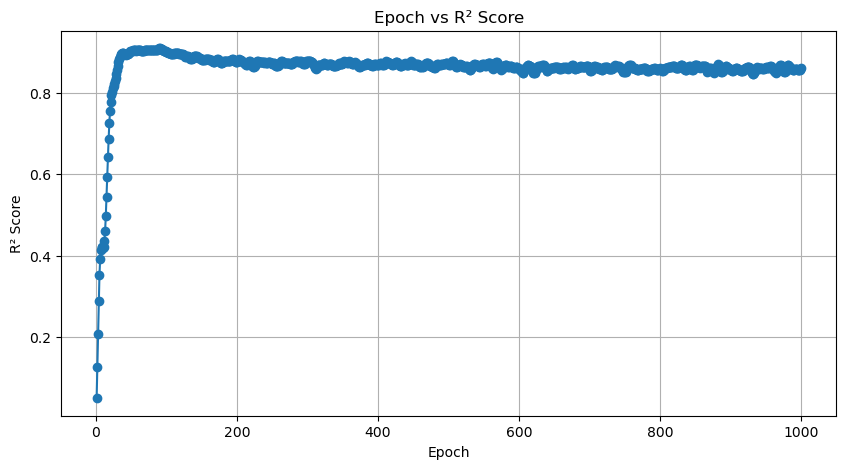

In [65]:
X = df_prep[selected_feature_names].apply(pd.to_numeric, errors='coerce').fillna(0)
y = df_prep['Price'].values.reshape(-1, 1)

scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)  # Scale y

X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_scaled, dtype=torch.float32)

X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.15,random_state=42)

class ComplexMLP(nn.Module):
    def __init__(self):
        super(ComplexMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(X_train.shape[1], 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.1),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.1),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        
    def forward(self, x):
        return self.layers(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ComplexMLP().to(device)
X_train = X_train.to(device)
y_train = y_train.to(device)
X_val = X_val.to(device)
y_val = y_val.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

num_epochs = 1000
r2_scores = []

for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)
    mse_loss = criterion(outputs, y_train)
    rmse_loss = torch.sqrt(mse_loss)

    optimizer.zero_grad()
    mse_loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        y_val_pred = model(X_val)
        y_val_pred_rescaled = scaler_y.inverse_transform(y_val_pred.cpu().numpy())
        y_val_rescaled = scaler_y.inverse_transform(y_val.cpu().numpy())
        val_r2 = r2_score(y_val_rescaled, y_val_pred_rescaled)
        r2_scores.append(val_r2)

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], MSE Loss: {mse_loss.item():.4f},\
        RMSE Loss: {rmse_loss.item():.4f}, R2 Score: {val_r2.item():.4f}')

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), r2_scores, marker='o', linestyle='-')
plt.title('Epoch vs R² Score')
plt.xlabel('Epoch')
plt.ylabel('R² Score')
plt.grid(True)
plt.show()

we can see that, the model is not improving alot, lets check plot with 100 epochs 

Epoch [10/100], MSE Loss: 0.1965,        RMSE Loss: 0.4433, R2 Score: 0.4117
Epoch [20/100], MSE Loss: 0.1435,        RMSE Loss: 0.3788, R2 Score: 0.7557
Epoch [30/100], MSE Loss: 0.1130,        RMSE Loss: 0.3361, R2 Score: 0.8699
Epoch [40/100], MSE Loss: 0.0989,        RMSE Loss: 0.3145, R2 Score: 0.8957
Epoch [50/100], MSE Loss: 0.0994,        RMSE Loss: 0.3152, R2 Score: 0.9045
Epoch [60/100], MSE Loss: 0.0837,        RMSE Loss: 0.2893, R2 Score: 0.9046
Epoch [70/100], MSE Loss: 0.0846,        RMSE Loss: 0.2909, R2 Score: 0.9038
Epoch [80/100], MSE Loss: 0.0797,        RMSE Loss: 0.2824, R2 Score: 0.8948
Epoch [90/100], MSE Loss: 0.0706,        RMSE Loss: 0.2656, R2 Score: 0.9047
Epoch [100/100], MSE Loss: 0.0662,        RMSE Loss: 0.2573, R2 Score: 0.8985


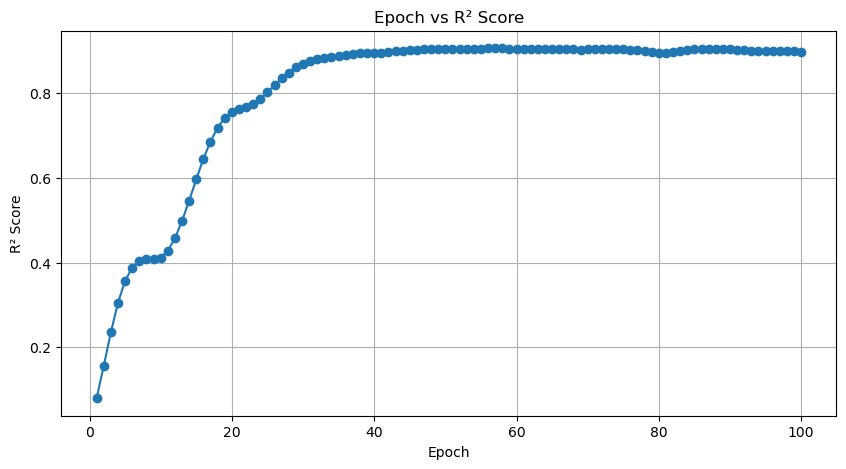

In [66]:
X = df_prep[selected_feature_names].apply(pd.to_numeric, errors='coerce').fillna(0)
y = df_prep['Price'].values.reshape(-1, 1)
X_test = df_test_prep[selected_feature_names].apply(pd.to_numeric, errors='coerce').fillna(0)
y_test = df_test_prep['Price'].values.reshape(-1, 1)
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)


scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)  # Scale y

X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_scaled, dtype=torch.float32)

X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.15,random_state=42)

class ComplexMLP(nn.Module):
    def __init__(self):
        super(ComplexMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(X_train.shape[1], 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.1),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.1),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        
    def forward(self, x):
        return self.layers(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ComplexMLP().to(device)
X_train = X_train.to(device)
y_train = y_train.to(device)
X_val = X_val.to(device)
y_val = y_val.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

num_epochs = 100
r2_scores = []

for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)
    mse_loss = criterion(outputs, y_train)
    rmse_loss = torch.sqrt(mse_loss)

    optimizer.zero_grad()
    mse_loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        y_val_pred = model(X_val)
        y_val_pred_rescaled = scaler_y.inverse_transform(y_val_pred.cpu().numpy())
        y_val_rescaled = scaler_y.inverse_transform(y_val.cpu().numpy())
        val_r2 = r2_score(y_val_rescaled, y_val_pred_rescaled)
        r2_scores.append(val_r2)

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], MSE Loss: {mse_loss.item():.4f},\
        RMSE Loss: {rmse_loss.item():.4f}, R2 Score: {val_r2.item():.4f}')

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), r2_scores, marker='o', linestyle='-')
plt.title('Epoch vs R² Score')
plt.xlabel('Epoch')
plt.ylabel('R² Score')
plt.grid(True)
plt.show()

In [67]:
with torch.no_grad():
    y_val_pred = model(X_val)
    y_val_pred_rescaled = scaler_y.inverse_transform(y_val_pred.cpu().numpy())
    y_val_rescaled = scaler_y.inverse_transform(y_val.cpu().numpy())
    val_r2 = r2_score(y_val_rescaled, y_val_pred_rescaled)
    
    print("R2 score: ",val_r2.item())
    print('MAE:', mean_absolute_error(y_val_rescaled, y_val_pred_rescaled).item())  
    print('RMSE:', mean_squared_error(y_val_rescaled, y_val_pred_rescaled,squared=False).item())

R2 score:  0.8985499739646912
MAE: 8924.814453125
RMSE: 12620.0478515625


In [68]:
model.eval()
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32).to(device)

with torch.no_grad():
    y_test_pred = model(X_test_tensor)
    y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred.cpu().numpy())
    y_test_rescaled = scaler_y.inverse_transform(y_test_tensor.cpu().numpy())
    test_r2 = r2_score(y_test_rescaled, y_test_pred_rescaled)
    print("Test Scores MLP")
    print("R2 score: ",test_r2.item())
    print('MAE:', mean_absolute_error(y_test_rescaled, y_test_pred_rescaled).item())  
    print('RMSE:', mean_squared_error(y_test_rescaled, y_test_pred_rescaled,squared=False).item())


Test Scores MLP
R2 score:  0.74493408203125
MAE: 12054.3232421875
RMSE: 18107.96875


8. Decision Tree

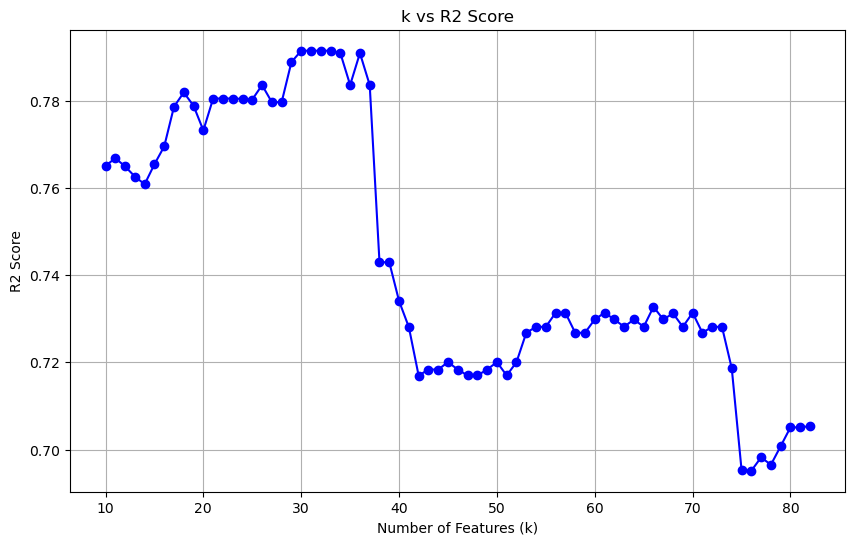

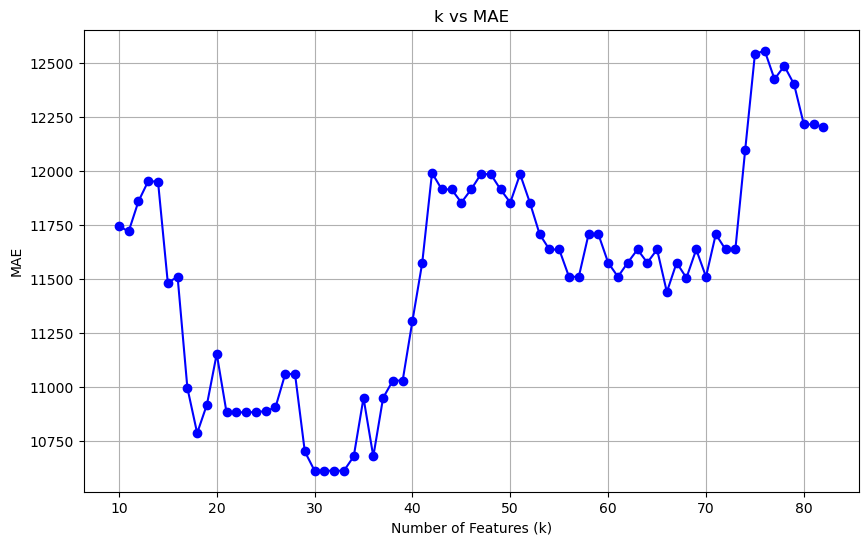

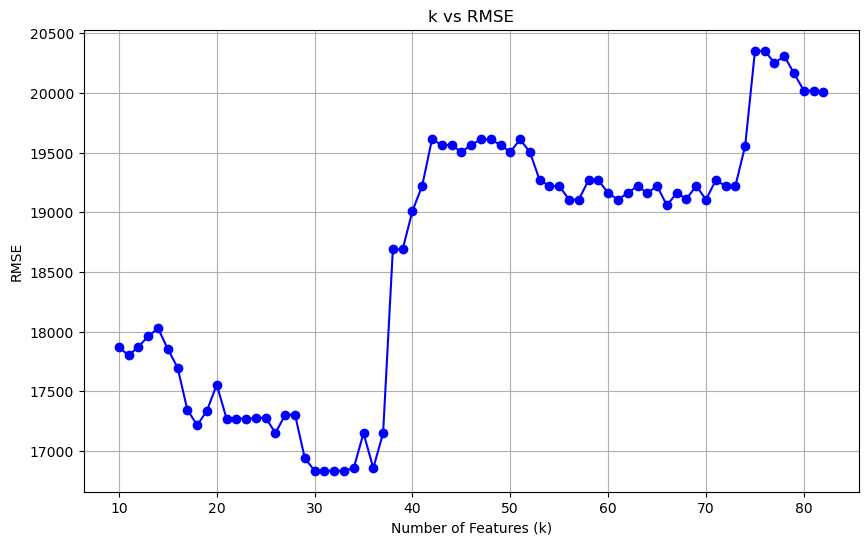

Best R2 k = 32, Best MAE k = 32


In [69]:
X = df_prep.drop(columns=['Price'])
y = df_prep['Price']
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')


k_values = list(range(10, 83))
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15,random_state=2)

param_grid = {
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}
grid_search = GridSearchCV(DecisionTreeRegressor(random_state=2),param_grid, cv=5, scoring='r2')

grid_search.fit(X_train, y_train)
model = grid_search.best_estimator_ 

train_df = pd.DataFrame(X_train)
train_df['y'] = y_train

correlation_matrix = train_df.corr()
correlation_with_target = correlation_matrix['y'].drop(labels=['y']).abs()

sorted_features = correlation_with_target.sort_values(ascending=False)

r2_scores = []
mae_val = []
RMSE_val = []

for k in k_values:
    top_k_features = sorted_features.head(k).index.tolist()

    X_train_selected = X_train[top_k_features]
    X_val_selected = X_val[top_k_features]

    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_val_selected)


    r2_scores.append(r2_score(y_val, y_pred))
    mae_val.append(mean_absolute_error(y_val, y_pred))
    RMSE_val.append(mean_squared_error(y_val, y_pred,squared= False))

plt.figure(figsize=(10, 6))
plt.plot(k_values, r2_scores, marker='o', linestyle='-', color='b')
plt.title('k vs R2 Score')
plt.xlabel('Number of Features (k)')
plt.ylabel('R2 Score')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(k_values, mae_val, marker='o', linestyle='-', color='b')
plt.title('k vs MAE')
plt.xlabel('Number of Features (k)')
plt.ylabel('MAE')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(k_values, RMSE_val, marker='o', linestyle='-', color='b')
plt.title('k vs RMSE')
plt.xlabel('Number of Features (k)')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()

r2_k = 10 + r2_scores.index(max(r2_scores))
mae_k = 10+ mae_val.index(min(mae_val))
print(f"Best R2 k = {r2_k}, Best MAE k = {mae_k}")

In [70]:
X = df_prep.drop(columns=['Price'])
y = df_prep['Price']
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')

#r2_k
print(f"Using k = {r2_k} best features")
selected_feature_names = sorted_features.head(r2_k).index.tolist()
X_SF = X[selected_feature_names]
X_train_SF, X_val_SF, y_train, y_val = train_test_split(X_SF, y, test_size=0.15, random_state=2)

param_grid = {
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}
grid_search = GridSearchCV(DecisionTreeRegressor(random_state=2), param_grid, cv=5, scoring='r2')

grid_search.fit(X_train, y_train)
model = grid_search.best_estimator_ 

model.fit(X_train_SF, y_train)
print("best grid search hyperparams: ",grid_search.best_params_)

y_pred = model.predict(X_val_SF)

print("\nValidation Scores")
print('R2 score:', r2_score(y_val, y_pred))
print('MAE:', mean_absolute_error(y_val, y_pred))
print('RMSE:', mean_squared_error(y_val, y_pred, squared= False))

# X_test_SF = X_test[selected_feature_names]
# y_test_pred_SF = model.predict(X_test_SF)

# Calculate and print the R2 score and MAE
# print("\nTest Scores")
# print('R2 score:', r2_score(y_test, y_test_pred_SF))
# print('MAE:', mean_absolute_error(y_test, y_test_pred_SF))
# print('RMSE:', mean_squared_error(y_test, y_test_pred_SF, squared= False))

Using k = 32 best features
best grid search hyperparams:  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}

Validation Scores
R2 score: 0.7914771065743244
MAE: 10610.593268284525
RMSE: 16833.70177924525


In [71]:
X = df_prep.drop(columns=['Price'])
y = df_prep['Price']
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')

#mae_k
print(f"Using k = {mae_k} best features")
selected_feature_names = sorted_features.head(r2_k).index.tolist()
X_SF = X[selected_feature_names]
X_train_SF, X_val_SF, y_train, y_val = train_test_split(X_SF, y, test_size=0.15, random_state=2)

model = Ridge()

model.fit(X_train_SF, y_train)

y_pred = model.predict(X_val_SF)

print("\nValidation Scores")
print('R2 score:', r2_score(y_val, y_pred))
print('MAE:', mean_absolute_error(y_val, y_pred))
print('RMSE:', mean_squared_error(y_val, y_pred, squared= False))

# X_test_SF = X_test[selected_feature_names]
# y_test_pred_SF = model.predict(X_test_SF)

# # Calculate and print the R2 score and MAE
# print("\nTest Scores")
# print('R2 score:', r2_score(y_test, y_test_pred_SF))
# print('MAE:', mean_absolute_error(y_test, y_test_pred_SF))
# print('RMSE:', mean_squared_error(y_test, y_test_pred_SF, squared= False))

Using k = 32 best features

Validation Scores
R2 score: 0.8075254495138483
MAE: 11988.997600722281
RMSE: 16172.956366365812


9. Random Forest

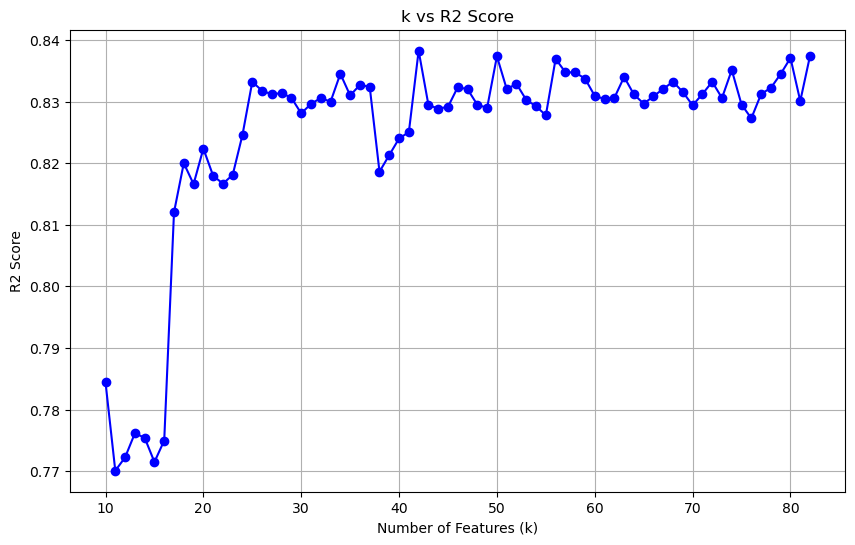

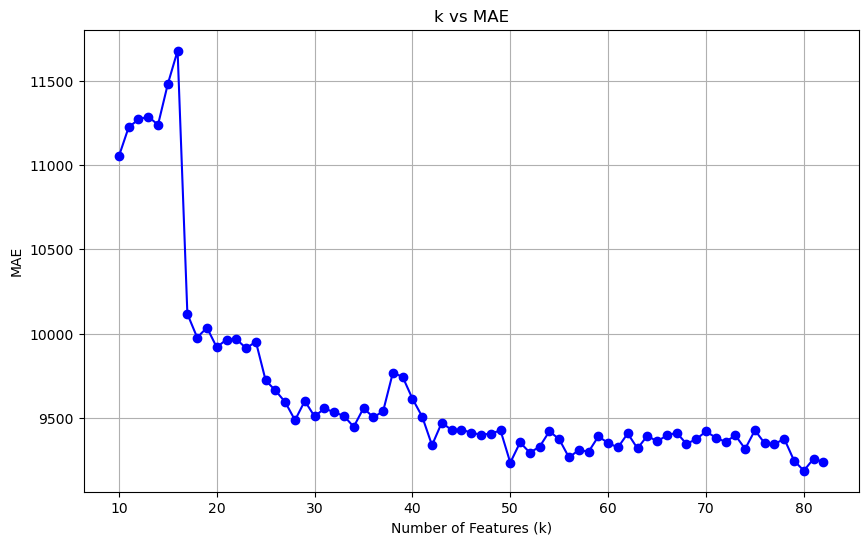

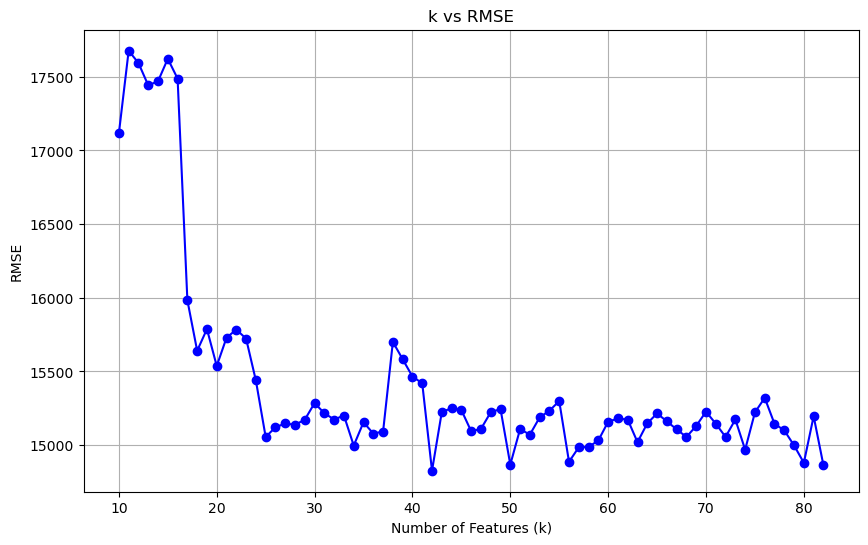

Best R2 k = 42, Best MAE k = 80


In [72]:
# for validation
X = df_prep.drop(columns=['Price'])
y = df_prep['Price']
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')
k_values = list(range(10, 83))
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=2)

param_grid = {
    'n_estimators': [100, 200, 300],  
    'max_depth': [None, 10, 20, 30],  
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4]     
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=2),param_grid, cv=5, scoring='r2', verbose=0, n_jobs=-1)

grid_search.fit(X_train, y_train)

model = grid_search.best_estimator_

train_df = pd.DataFrame(X_train)
train_df['y'] = y_train

correlation_matrix = train_df.corr()
correlation_with_target = correlation_matrix['y'].drop(labels=['y']).abs()

sorted_features = correlation_with_target.sort_values(ascending=False)

r2_scores = []
mae_val = []
RMSE_val = []

for k in k_values:
    top_k_features = sorted_features.head(k).index.tolist()

    X_train_selected = X_train[top_k_features]
    X_val_selected = X_val[top_k_features]

    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_val_selected)


    r2_scores.append(r2_score(y_val, y_pred))
    mae_val.append(mean_absolute_error(y_val, y_pred))
    RMSE_val.append(mean_squared_error(y_val, y_pred,squared= False))

plt.figure(figsize=(10, 6))
plt.plot(k_values, r2_scores, marker='o', linestyle='-', color='b')
plt.title('k vs R2 Score')
plt.xlabel('Number of Features (k)')
plt.ylabel('R2 Score')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(k_values, mae_val, marker='o', linestyle='-', color='b')
plt.title('k vs MAE')
plt.xlabel('Number of Features (k)')
plt.ylabel('MAE')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(k_values, RMSE_val, marker='o', linestyle='-', color='b')
plt.title('k vs RMSE')
plt.xlabel('Number of Features (k)')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()

r2_k = 10 + r2_scores.index(max(r2_scores))
mae_k = 10+ mae_val.index(min(mae_val))
print(f"Best R2 k = {r2_k}, Best MAE k = {mae_k}")

In [73]:
X = df_prep.drop(columns=['Price'])
y = df_prep['Price']
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')

X_test = df_test_prep.drop(columns=['Price'])
y_test = df_test_prep['Price']
X_test = X_test.apply(pd.to_numeric, errors='coerce')
y_test = pd.to_numeric(y_test, errors='coerce')

#r2_k
print(f"Using k = {r2_k} best features")
selected_feature_names = sorted_features.head(r2_k).index.tolist()
X_SF = X[selected_feature_names]
X_train_SF, X_val_SF, y_train, y_val = train_test_split(X_SF, y, test_size=0.15, random_state=2)

param_grid = {
    'n_estimators': [100, 200, 300],  
    'max_depth': [None, 10, 20, 30],  
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]     
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=2),param_grid, cv=5, scoring='r2', verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

model = grid_search.best_estimator_
print("best grid search hyperparams: ",grid_search.best_params_)
model.fit(X_train_SF, y_train)

y_pred = model.predict(X_val_SF)

print("\nValidation Scores")
print('R2 score:', r2_score(y_val, y_pred))
print('MAE:', mean_absolute_error(y_val, y_pred))
print('RMSE:', mean_squared_error(y_val, y_pred, squared= False))

X_test_SF = X_test[selected_feature_names]
y_test_pred_SF = model.predict(X_test_SF)

print("\nTest Scores")
print('R2 score:', r2_score(y_test, y_test_pred_SF))
print('MAE:', mean_absolute_error(y_test, y_test_pred_SF))
print('RMSE:', mean_squared_error(y_test, y_test_pred_SF, squared= False))

Using k = 42 best features
Fitting 5 folds for each of 108 candidates, totalling 540 fits
best grid search hyperparams:  {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Validation Scores
R2 score: 0.8382531088424692
MAE: 9336.134680585701
RMSE: 14825.88847455018

Test Scores
R2 score: 0.744208688797624
MAE: 11631.411217646302
RMSE: 18133.70146339271


In [74]:
X = df_prep.drop(columns=['Price'])
y = df_prep['Price']
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')


X_test = df_test_prep.drop(columns=['Price'])
y_test = df_test_prep['Price']
X_test = X_test.apply(pd.to_numeric, errors='coerce')
y_test = pd.to_numeric(y_test, errors='coerce')

#mae_k
print(f"Using k = {mae_k} best features")
selected_feature_names = sorted_features.head(r2_k).index.tolist()
X_SF = X[selected_feature_names]
X_train_SF, X_val_SF, y_train, y_val = train_test_split(X_SF, y,test_size=0.15, random_state=2)

param_grid = {
    'n_estimators': [100, 200, 300], 
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4]     
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=2), param_grid, cv=5, scoring='r2', verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

model = grid_search.best_estimator_
model.fit(X_train_SF, y_train)

y_pred = model.predict(X_val_SF)

print("\nValidation Scores")
print('R2 score:', r2_score(y_val, y_pred))
print('MAE:', mean_absolute_error(y_val, y_pred))
print('RMSE:', mean_squared_error(y_val, y_pred, squared= False))

X_test_SF = X_test[selected_feature_names]
y_test_pred_SF = model.predict(X_test_SF)

print("\nTest Scores")
print('R2 score:', r2_score(y_test, y_test_pred_SF))
print('MAE:', mean_absolute_error(y_test, y_test_pred_SF))
print('RMSE:', mean_squared_error(y_test, y_test_pred_SF, squared= False))

Using k = 80 best features
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Validation Scores
R2 score: 0.8382531088424692
MAE: 9336.134680585701
RMSE: 14825.88847455018

Test Scores
R2 score: 0.744208688797624
MAE: 11631.411217646302
RMSE: 18133.70146339271


10. KNN for Regression

Fitting 5 folds for each of 76 candidates, totalling 380 fits


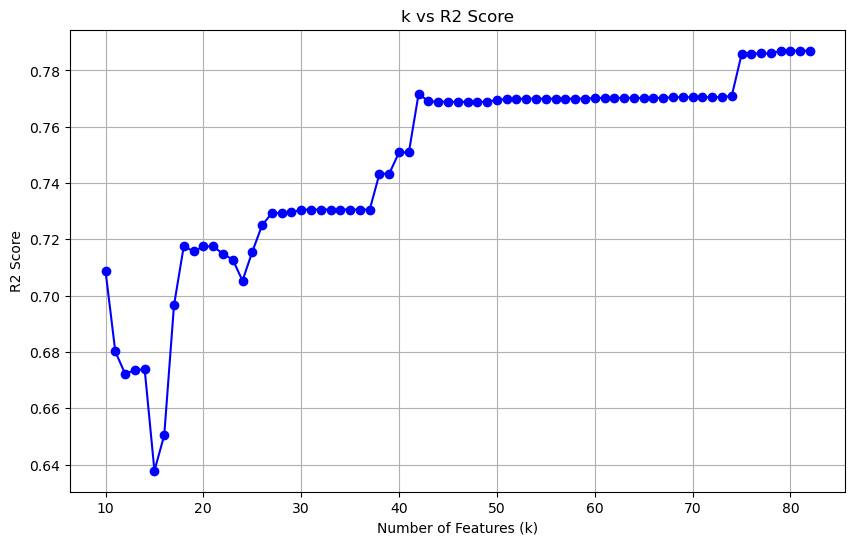

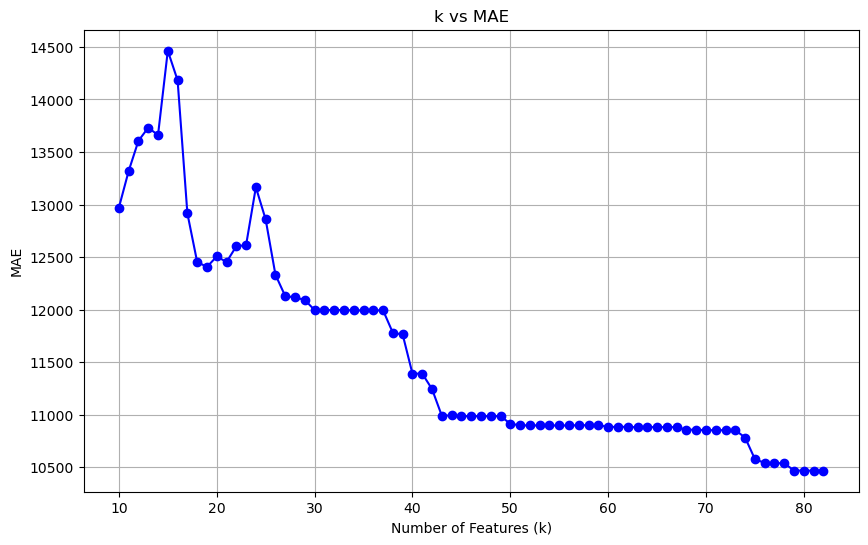

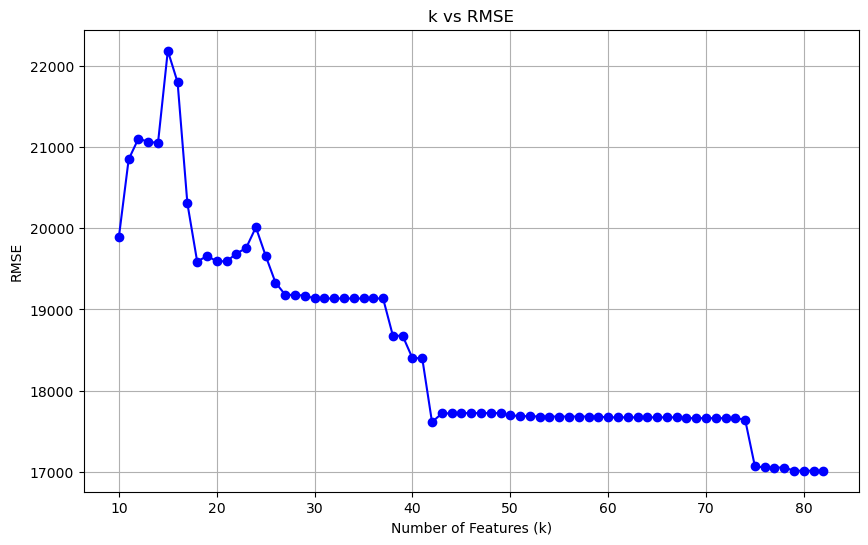

Best R2 k = 81, Best MAE k = 81


In [75]:
X = df_prep.drop(columns=['Price'])
y = df_prep['Price']
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')
k_values = list(range(10, 83))
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=2)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

param_grid = {
    'n_neighbors': range(1, 20),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='r2', verbose=1)
grid_search.fit(X_train_scaled, y_train)

model = grid_search.best_estimator_


train_df = pd.DataFrame(X_train)
train_df['y'] = y_train

correlation_matrix = train_df.corr()
correlation_with_target = correlation_matrix['y'].drop(labels=['y']).abs()

sorted_features = correlation_with_target.sort_values(ascending=False)

r2_scores = []
mae_val = []
RMSE_val = []

for k in k_values:
    top_k_features = sorted_features.head(k).index.tolist()

    X_train_selected = X_train[top_k_features]
    X_val_selected = X_val[top_k_features]

    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_val_selected)


    r2_scores.append(r2_score(y_val, y_pred))
    mae_val.append(mean_absolute_error(y_val, y_pred))
    RMSE_val.append(mean_squared_error(y_val, y_pred,squared= False))

plt.figure(figsize=(10, 6))
plt.plot(k_values, r2_scores, marker='o', linestyle='-', color='b')
plt.title('k vs R2 Score')
plt.xlabel('Number of Features (k)')
plt.ylabel('R2 Score')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(k_values, mae_val, marker='o', linestyle='-', color='b')
plt.title('k vs MAE')
plt.xlabel('Number of Features (k)')
plt.ylabel('MAE')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(k_values, RMSE_val, marker='o', linestyle='-', color='b')
plt.title('k vs RMSE')
plt.xlabel('Number of Features (k)')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()

r2_k = 10 + r2_scores.index(max(r2_scores))
mae_k = 10+ mae_val.index(min(mae_val))
print(f"Best R2 k = {r2_k}, Best MAE k = {mae_k}")

In [76]:
X = df_prep.drop(columns=['Price'])
y = df_prep['Price']
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')


#r2_k
print(f"Using k = {r2_k} best features")
selected_feature_names = sorted_features.head(r2_k).index.tolist()
X_SF = X[selected_feature_names]
X_train_SF, X_val_SF, y_train, y_val = train_test_split(X_SF, y,test_size=0.15, random_state=2)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_SF)
X_val_scaled = scaler.transform(X_val_SF)

param_grid = {
    'n_neighbors': range(1, 20),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='r2', verbose=1)
grid_search.fit(X_train_scaled, y_train)


model = grid_search.best_estimator_
model.fit(X_train_SF, y_train)
print("best grid search hyperparams: ",grid_search.best_params_)


y_pred = model.predict(X_val_SF)

print("\nValidation Scores")
print('R2 score:', r2_score(y_val, y_pred))
print('MAE:', mean_absolute_error(y_val, y_pred))
print('RMSE:', mean_squared_error(y_val, y_pred, squared= False))

X_test_SF = X_test[selected_feature_names]
y_test_pred_SF = model.predict(X_test_SF)

# Calculate and print the R2 score and MAE
# print("\nTest Scores")
# print('R2 score:', r2_score(y_test, y_test_pred_SF))
# print('MAE:', mean_absolute_error(y_test, y_test_pred_SF))
# print('RMSE:', mean_squared_error(y_test, y_test_pred_SF, squared= False))

Using k = 81 best features
Fitting 5 folds for each of 76 candidates, totalling 380 fits
best grid search hyperparams:  {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}

Validation Scores
R2 score: 0.7869869913988555
MAE: 10466.03509536839
RMSE: 17013.97620310677


In [77]:

X = df_prep.drop(columns=['Price'])
y = df_prep['Price']
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')


#mae_k
print(f"Using k = {mae_k} best features")
selected_feature_names = sorted_features.head(mae_k).index.tolist()
X_SF = X[selected_feature_names]
X_train_SF, X_val_SF, y_train, y_val = train_test_split(X_SF, y,
                                    test_size=0.15, random_state=2)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_SF)
X_val_scaled = scaler.transform(X_val_SF)

param_grid = {
    'n_neighbors': range(1, 20),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='r2', verbose=1)
grid_search.fit(X_train_scaled, y_train)


model = grid_search.best_estimator_
model.fit(X_train_SF, y_train)

y_pred = model.predict(X_val_SF)

print("\nValidation Scores")
print('R2 score:', r2_score(y_val, y_pred))
print('MAE:', mean_absolute_error(y_val, y_pred))
print('RMSE:', mean_squared_error(y_val, y_pred, squared= False))

X_test_SF = X_test[selected_feature_names]
y_test_pred_SF = model.predict(X_test_SF)

# Calculate and print the R2 score and MAE
# print("\nTest Scores")
# print('R2 score:', r2_score(y_test, y_test_pred_SF))
# print('MAE:', mean_absolute_error(y_test, y_test_pred_SF))
# print('RMSE:', mean_squared_error(y_test, y_test_pred_SF, squared= False))

Using k = 81 best features
Fitting 5 folds for each of 76 candidates, totalling 380 fits

Validation Scores
R2 score: 0.7869869913988555
MAE: 10466.03509536839
RMSE: 17013.97620310677
